# [LSTM 실습: 다변량 시계열 예측 모델링 및 비교]

### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)
- y: Code로 변경
- m: Markdown으로 변경

### 1. 모듈 불러오기

In [29]:
import pandas as pd
import pandas_datareader.data as pdr
# pip install pandas-datareader

import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

0.4.1
Populating the interactive namespace from numpy and matplotlib


#### 정규화 함수

In [30]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

### 2. 데이터 불러오기
##### Pandas Datareader 사용: 야후에서 제공하는 API사용
#####  
#####  

- X: 주식 정보(High, Low, Open, Close, Volumne, Adj Close)
- y: 주식 정보(High, Low, Open, Close, Volumne, Adj Close) 중 택 1

In [31]:
# We will look at stock prices over the past year
start = (2000, 12, 1)
start = datetime.datetime(*start) #그냥 tuple로 넣어주면 안됨, *: 인자를 각각 순서대로 넣어줌
end = datetime.date.today()

# google = pdr.DataReader('어떤종목', '어디서', 언제부터, 언제까지)                    
yahoo = pdr.DataReader('AAPL', 'yahoo', start, end)

# 한화: 000880.KS
# 한화 케미칼: 009830.KS
# 한화 손해보험: 000370.KS
# 모나미: 005360.KS
# 하이트진로홀딩스우: 000145.KS

#### 데이터 탐색

In [32]:
print(yahoo.head())
# High: 장 중 제일 높았던 주가(고가)
# Low: 장 중 제일 낮았던 주가(저가)
# Open: 장 시작 때 주가(시가)
# Close: 장 닫을 때 주가(종가)
# Volume: 주식 거래량
# Adj Close: 주식의 분할, 배당, 배분 등을 고려해 조정한 종가

                High       Low      Open     Close       Volume  Adj Close
Date                                                                      
2000-11-30  1.214286  1.151786  1.191964  1.178571  202399400.0   1.032463
2000-12-01  1.250000  1.200893  1.214286  1.218750   96426400.0   1.067660
2000-12-04  1.227679  1.174107  1.227679  1.191964   92880200.0   1.044195
2000-12-05  1.245536  1.169643  1.209821  1.214286  153494600.0   1.063749
2000-12-06  1.071429  1.000000  1.044643  1.022321  343616000.0   0.895583


In [33]:
print(yahoo.describe())

              High          Low         Open        Close        Volume  \
count  4692.000000  4692.000000  4692.000000  4692.000000  4.692000e+03   
mean     58.685247    57.569812    58.139846    58.142208  1.167176e+08   
std      60.410390    59.408928    59.900932    59.923061  9.672535e+07   
min       0.942143     0.908571     0.927857     0.937143  9.835000e+06   
25%       6.404464     6.244643     6.316786     6.311964  4.850305e+07   
50%      34.088572    33.169285    33.720715    33.702143  8.890140e+07   
75%      99.300003    97.324999    98.344646    98.127502  1.540704e+08   
max     233.470001   229.779999   230.779999   232.070007  8.432424e+08   

         Adj Close  
count  4692.000000  
mean     54.573648  
std      58.578110  
min       0.820964  
25%       5.529463  
50%      29.524055  
75%      91.650183  
max     229.392090  


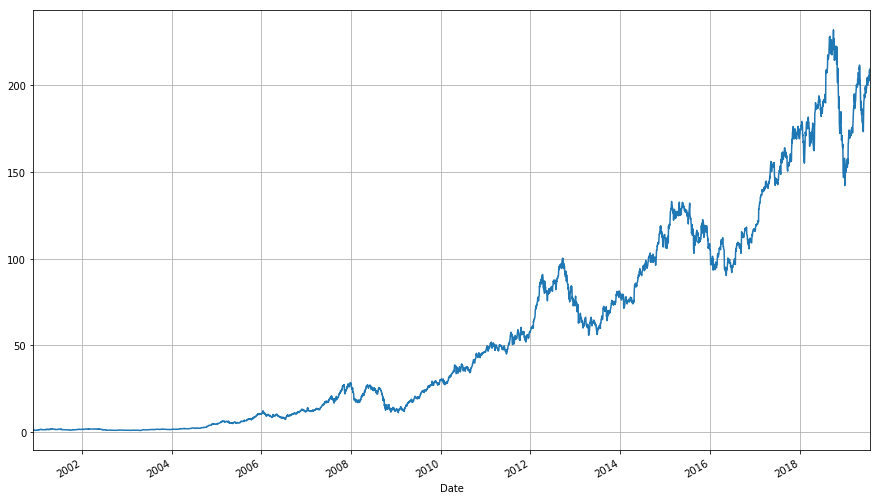

In [34]:
yahoo.Close.plot(grid=True)  # Close --> change

In [35]:
data_rvs = yahoo

#### hyperparameters
- seq_length: 시퀀스 길이
- data_dim: 변수 개수
- hidden_dim: hidden state vector 차원(=특징을 얼마나 추출하여 학습할 것인지)
- output_dim: 학습 반복 회수
- learning_rate: 학습률
- iterations: 학습 반복 회수

In [8]:
seq_length = 7    # 반영하고자 하는 날짜
data_dim = 6      # 변수 갯수 
hidden_dim = 10
output_dim = 1    # 예측 변수 갯수
learning_rate = 0.01
iterations = 500 

In [9]:
# split train-test set
train_size = int(len(data_rvs) * 0.7)
train_set = data_rvs[0:train_size]
test_set = data_rvs[train_size - seq_length:]

In [10]:
# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

In [11]:
print(train_set.head())

                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2000-11-30  0.002727  0.002456  0.002657  0.002430  0.231057   0.002419
2000-12-01  0.003085  0.002952  0.002881  0.002834  0.103900   0.002822
2000-12-04  0.002862  0.002681  0.003016  0.002565  0.099645   0.002553
2000-12-05  0.003041  0.002636  0.002836  0.002789  0.172376   0.002777
2000-12-06  0.001296  0.000923  0.001175  0.000857  0.400502   0.000854


### 3. 데이터 전처리: sequence 길이에 맞게  RNN Input 데이터 만들기

In [12]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series.iloc[i:i + seq_length, :]
        _y = time_series.iloc[i + seq_length, [3]]  # Next close price  #[3,4]: Close and volume
        print(_x, "->", _y)
        dataX.append(_x.values)
        dataY.append(_y.values)
    
    return np.stack(dataX), np.stack(dataY)

In [13]:
# Remind

#seq_length = 7    # 반영하고자 하는 날짜
#data_dim = 6      # 변수 갯수 
#hidden_dim = 10
#output_dim = 1    # 예측 변수 갯수
#learning_rate = 0.01
#iterations = 500 

In [14]:
# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2000-11-30  0.002727  0.002456  0.002657  0.002430  0.231057   0.002419
2000-12-01  0.003085  0.002952  0.002881  0.002834  0.103900   0.002822
2000-12-04  0.002862  0.002681  0.003016  0.002565  0.099645   0.002553
2000-12-05  0.003041  0.002636  0.002836  0.002789  0.172376   0.002777
2000-12-06  0.001296  0.000923  0.001175  0.000857  0.400502   0.000854
2000-12-07  0.001206  0.000923  0.001040  0.000857  0.110863   0.000854
2000-12-08  0.001519  0.001239  0.001309  0.001396  0.118875   0.001390 -> Close    0.001486
Name: 2000-12-11 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2000-12-01  0.003085  0.002952  0.002881  0.002834  0.103900   0.002822
2000-12-04  0.002862  0.002681  0.003016  0.002565  0.099645   0.002553
2

2001-02-08  0.005635  0.005386  0.005441  0.005485  0.169421   0.005461 -> Close    0.004317
Name: 2001-02-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-02-01  0.005949  0.005612  0.005530  0.005755  0.099098   0.005730
2001-02-02  0.006262  0.005612  0.005845  0.005395  0.116390   0.005372
2001-02-05  0.005278  0.005071  0.005396  0.005081  0.074026   0.005059
2001-02-06  0.005870  0.005251  0.005149  0.005755  0.127000   0.005730
2001-02-07  0.005501  0.005116  0.005508  0.005485  0.106355   0.005461
2001-02-08  0.005635  0.005386  0.005441  0.005485  0.169421   0.005461
2001-02-09  0.005457  0.004304  0.005396  0.004317  0.165208   0.004298 -> Close    0.004721
Name: 2001-02-12 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-02-02

2001-03-02  0.005188  0.003989  0.003824  0.004407  0.110049   0.004388 -> Close    0.005215
Name: 2001-03-05 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-02-23  0.004070  0.003989  0.004049  0.004092  0.076351   0.004074
2001-02-26  0.004651  0.004214  0.004363  0.004586  0.050125   0.004567
2001-02-27  0.004472  0.004304  0.004520  0.004497  0.092745   0.004477
2001-02-28  0.004472  0.003899  0.004587  0.003688  0.140656   0.003672
2001-03-01  0.003980  0.003222  0.003465  0.004047  0.087329   0.004030
2001-03-02  0.005188  0.003989  0.003824  0.004407  0.110049   0.004388
2001-03-05  0.005233  0.004710  0.004587  0.005215  0.085442   0.005193 -> Close    0.006024
Name: 2001-03-06 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-02-26

2001-05-09  0.008132  0.007898  0.008011  0.007807  0.085657   0.007773 -> Close    0.007102
Name: 2001-05-10 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-05-02  0.009671  0.009406  0.009592  0.009683  0.098747   0.009641
2001-05-03  0.009349  0.008663  0.009326  0.008511  0.078654   0.008475
2001-05-04  0.009063  0.008107  0.008083  0.009079  0.072507   0.009040
2001-05-07  0.008998  0.008742  0.009074  0.008511  0.071157   0.008475
2001-05-08  0.008776  0.008100  0.008880  0.008231  0.082822   0.008195
2001-05-09  0.008132  0.007898  0.008011  0.007807  0.085657   0.007773
2001-05-10  0.008096  0.007379  0.008061  0.007102  0.074884   0.007072 -> Close    0.006995
Name: 2001-05-11 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-05-03

2001-06-18  0.005483  0.005251  0.005331  0.005183  0.091963   0.005161 -> Close    0.005082
Name: 2001-06-19 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-06-11  0.005641  0.005215  0.005791  0.004975  0.076391   0.004953
2001-06-12  0.005369  0.005078  0.004871  0.005169  0.079329   0.005146
2001-06-13  0.006113  0.005294  0.006057  0.005284  0.141632   0.005261
2001-06-14  0.005197  0.005085  0.005065  0.004860  0.077396   0.004839
2001-06-15  0.005412  0.004782  0.005108  0.005262  0.124574   0.005239
2001-06-18  0.005483  0.005251  0.005331  0.005183  0.091963   0.005161
2001-06-19  0.005877  0.005258  0.005647  0.005082  0.084517   0.005060 -> Close    0.006146
Name: 2001-06-20 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-06-12

2001-08-15  0.004116  0.003953  0.004146  0.003824  0.074975   0.003808 -> Close    0.003975
Name: 2001-08-16 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-08-08  0.004660  0.004198  0.004505  0.004155  0.071043   0.004137
2001-08-09  0.004266  0.004328  0.004289  0.004263  0.048393   0.004244
2001-08-10  0.004388  0.004234  0.004347  0.004241  0.044283   0.004223
2001-08-13  0.004395  0.004357  0.004390  0.004292  0.032594   0.004273
2001-08-14  0.004417  0.004292  0.004462  0.004033  0.056878   0.004015
2001-08-15  0.004116  0.003953  0.004146  0.003824  0.074975   0.003808
2001-08-16  0.003980  0.003787  0.003794  0.003975  0.074619   0.003958 -> Close    0.003558
Name: 2001-08-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-08-09

2001-09-21  0.002190  0.001414  0.001300  0.001876  0.159339   0.001868 -> Close    0.002394
Name: 2001-09-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-09-10  0.003085  0.003029  0.002881  0.003055  0.080844   0.003042
2001-09-17  0.002777  0.002171  0.002163  0.002782  0.125589   0.002770
2001-09-18  0.003243  0.002488  0.002809  0.002272  0.086321   0.002262
2001-09-19  0.002799  0.002077  0.002522  0.002804  0.100185   0.002791
2001-09-20  0.002692  0.002005  0.002371  0.001840  0.111540   0.001832
2001-09-21  0.002190  0.001414  0.001300  0.001876  0.159339   0.001868
2001-09-24  0.002613  0.002330  0.002242  0.002394  0.076552   0.002383 -> Close    0.00174
Name: 2001-09-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-09-17 

2001-11-16  0.004367  0.004097  0.004512  0.004205  0.057392   0.004187 -> Close    0.004946
Name: 2001-11-19 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-11-09  0.004338  0.004205  0.004031  0.004018  0.028484   0.004001
2001-11-12  0.004281  0.003780  0.004074  0.004047  0.048643   0.004030
2001-11-13  0.004438  0.004320  0.004376  0.004493  0.055595   0.004474
2001-11-14  0.004803  0.004638  0.004742  0.004665  0.054538   0.004645
2001-11-15  0.004803  0.004696  0.004641  0.004550  0.052102   0.004531
2001-11-16  0.004367  0.004097  0.004512  0.004205  0.057392   0.004187
2001-11-19  0.004911  0.004501  0.004318  0.004946  0.087967   0.004924 -> Close    0.004608
Name: 2001-11-20 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-11-12

2001-12-31  0.006779  0.006571  0.006840  0.006312  0.029530   0.006284 -> Close    0.007318
Name: 2002-01-02 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-12-21  0.005977  0.005828  0.005762  0.005665  0.065093   0.005640
2001-12-24  0.005913  0.005900  0.005683  0.005923  0.003387   0.005898
2001-12-26  0.006521  0.006073  0.006006  0.006017  0.032115   0.005991
2001-12-27  0.006486  0.006391  0.006172  0.006434  0.045647   0.006406
2001-12-28  0.007022  0.006665  0.006452  0.006693  0.077928   0.006664
2001-12-31  0.006779  0.006571  0.006840  0.006312  0.029530   0.006284
2002-01-02  0.007237  0.006665  0.006509  0.007318  0.147034   0.007286 -> Close    0.007519
Name: 2002-01-03 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2001-12-24

2002-02-27  0.007917  0.005929  0.007867  0.006355  0.297219   0.006327 -> Close    0.006168
Name: 2002-02-28 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-02-20  0.007166  0.006946  0.007027  0.007196  0.073824   0.007165
2002-02-21  0.007022  0.006297  0.007134  0.006024  0.122212   0.005998
2002-02-22  0.006987  0.006333  0.006229  0.006915  0.110131   0.006886
2002-02-25  0.008254  0.006953  0.007084  0.007685  0.116242   0.007652
2002-02-26  0.008003  0.007595  0.007846  0.007584  0.066231   0.007551
2002-02-27  0.007917  0.005929  0.007867  0.006355  0.297219   0.006327
2002-02-28  0.006729  0.006225  0.006581  0.006168  0.125268   0.006141 -> Close    0.007426
Name: 2002-03-01 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-02-21

2002-04-15  0.008562  0.008713  0.008672  0.008540  0.078002   0.008503 -> Close    0.009072
Name: 2002-04-16 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-04-08  0.008225  0.007977  0.008025  0.008224  0.066646   0.008188
2002-04-09  0.008454  0.008143  0.008334  0.007893  0.045653   0.007859
2002-04-10  0.008418  0.008143  0.008061  0.008296  0.055687   0.008260
2002-04-11  0.008597  0.008677  0.008650  0.008439  0.110365   0.008403
2002-04-12  0.008576  0.008547  0.008636  0.008583  0.084263   0.008546
2002-04-15  0.008562  0.008713  0.008672  0.008540  0.078002   0.008503
2002-04-16  0.009163  0.008944  0.008737  0.009072  0.172556   0.009033 -> Close    0.009338
Name: 2002-04-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-04-09

2002-05-29  0.008053  0.007739  0.007853  0.007807  0.054731   0.007773 -> Close    0.007965
Name: 2002-05-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-05-21  0.008454  0.007703  0.008507  0.007433  0.072489   0.007401
2002-05-22  0.008003  0.007646  0.007458  0.008051  0.075454   0.008017
2002-05-23  0.008626  0.008187  0.008234  0.008670  0.099009   0.008632
2002-05-24  0.008447  0.008107  0.008622  0.007929  0.038047   0.007895
2002-05-28  0.007881  0.007725  0.007688  0.007807  0.033110   0.007773
2002-05-29  0.008053  0.007739  0.007853  0.007807  0.054731   0.007773
2002-05-30  0.008010  0.007783  0.007745  0.007965  0.047106   0.007931 -> Close    0.007318
Name: 2002-05-31 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-05-22

                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-07-02  0.002842  0.002964  0.002903  0.002746  0.079748   0.002734
2002-07-03  0.003214  0.002907  0.002745  0.003185  0.047903   0.003171
2002-07-05  0.003980  0.003599  0.003391  0.004040  0.036690   0.004023
2002-07-08  0.003880  0.003578  0.003973  0.003515  0.051555   0.003500
2002-07-09  0.003651  0.003419  0.003664  0.003170  0.056218   0.003157
2002-07-10  0.003565  0.003267  0.003391  0.003019  0.050258   0.003006
2002-07-11  0.003694  0.003065  0.003068  0.003724  0.100292   0.003708 -> Close    0.003156
Name: 2002-07-12 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-07-03  0.003214  0.002907  0.002745  0.003185  0.047903   0.003171
2002-07-05  0.003980  0.003599  0.003391  0.004040  0.036690   0.004023
2

2002-09-09  0.000959  0.001031  0.000927  0.000899  0.035668   0.000895 -> Close    0.00087
Name: 2002-09-10 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-08-30  0.001396  0.001342  0.001250  0.001172  0.046250   0.001167
2002-09-03  0.000974  0.000959  0.001078  0.000669  0.071273   0.000666
2002-09-04  0.001138  0.001046  0.000869  0.000978  0.114386   0.000973
2002-09-05  0.000838  0.000959  0.000884  0.000762  0.056047   0.000759
2002-09-06  0.001045  0.001089  0.001092  0.000906  0.042672   0.000902
2002-09-09  0.000959  0.001031  0.000927  0.000899  0.035668   0.000895
2002-09-10  0.000931  0.001010  0.001020  0.000870  0.063033   0.000866 -> Close    0.000841
Name: 2002-09-11 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-09-03 

2002-10-23  0.001281  0.001284  0.001178  0.001265  0.050905   0.001260 -> Close    0.001129
Name: 2002-10-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-10-16  0.001389  0.000851  0.001344  0.001035  0.080478   0.001031
2002-10-17  0.000852  0.000909  0.000877  0.000712  0.128976   0.000709
2002-10-18  0.000830  0.000873  0.000726  0.000877  0.074681   0.000873
2002-10-21  0.001031  0.000923  0.000912  0.001035  0.059749   0.001031
2002-10-22  0.001210  0.001111  0.001063  0.001136  0.053638   0.001131
2002-10-23  0.001281  0.001284  0.001178  0.001265  0.050905   0.001260
2002-10-24  0.001446  0.001320  0.001459  0.001129  0.040619   0.001124 -> Close    0.001653
Name: 2002-10-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-10-17

2002-12-06  0.001432  0.001298  0.001193  0.001316  0.061800   0.001310 -> Close    0.001172
Name: 2002-12-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-11-29  0.001926  0.001940  0.002012  0.001711  0.031225   0.001704
2002-12-02  0.002083  0.001652  0.002091  0.001481  0.107811   0.001474
2002-12-03  0.001539  0.001717  0.001588  0.001466  0.056554   0.001460
2002-12-04  0.001432  0.001284  0.001573  0.001330  0.085918   0.001324
2002-12-05  0.001353  0.001306  0.001466  0.001085  0.061212   0.001081
2002-12-06  0.001432  0.001298  0.001193  0.001316  0.061800   0.001310
2002-12-09  0.001260  0.001407  0.001401  0.001172  0.059018   0.001167 -> Close    0.001553
Name: 2002-12-10 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-12-02

2003-01-29  0.001367  0.001140  0.001121  0.001301  0.100102   0.001296 -> Close    0.000863
Name: 2003-01-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-01-22  0.000687  0.000779  0.000711  0.000546  0.052736   0.000544
2003-01-23  0.000838  0.000887  0.000762  0.000755  0.056670   0.000752
2003-01-24  0.000752  0.000606  0.000898  0.000489  0.079832   0.000487
2003-01-27  0.000938  0.000671  0.000496  0.000726  0.105611   0.000723
2003-01-28  0.001074  0.001039  0.000898  0.001050  0.074068   0.001045
2003-01-29  0.001367  0.001140  0.001121  0.001301  0.100102   0.001296
2003-01-30  0.001346  0.001132  0.001430  0.000863  0.110306   0.000859 -> Close    0.000891
Name: 2003-01-31 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-01-23

2003-03-25  0.001174  0.001190  0.001020  0.001028  0.038504   0.001024 -> Close    0.000927
Name: 2003-03-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-03-18  0.001360  0.001515  0.001444  0.001351  0.057187   0.001346
2003-03-19  0.001403  0.001493  0.001494  0.001316  0.030590   0.001310
2003-03-20  0.001289  0.001356  0.001394  0.001287  0.037148   0.001281
2003-03-21  0.001403  0.001515  0.001509  0.001351  0.077576   0.001346
2003-03-24  0.001153  0.001176  0.001207  0.000899  0.036525   0.000895
2003-03-25  0.001174  0.001190  0.001020  0.001028  0.038504   0.001024
2003-03-26  0.000981  0.001140  0.001121  0.000927  0.041697   0.000923 -> Close    0.000985
Name: 2003-03-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-03-19

2003-04-22  0.000308  0.000267  0.000137  0.000280  0.078362   0.000279 -> Close    0.000331
Name: 2003-04-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-04-14  0.000401  0.000563  0.000517  0.000331  0.139073   0.000329
2003-04-15  0.000293  0.000418  0.000431  0.000194  0.079381   0.000193
2003-04-16  0.000344  0.000144  0.000000  0.000086  0.293025   0.000086
2003-04-17  0.000043  0.000000  0.000151  0.000000  0.173060   0.000000
2003-04-21  0.000000  0.000188  0.000101  0.000014  0.033891   0.000014
2003-04-22  0.000308  0.000267  0.000137  0.000280  0.078362   0.000279
2003-04-23  0.000315  0.000462  0.000388  0.000331  0.051098   0.000329 -> Close    0.00023
Name: 2003-04-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-04-15 

2003-06-20  0.004574  0.004458  0.004570  0.004371  0.095153   0.004352 -> Close    0.00427
Name: 2003-06-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-06-13  0.003407  0.003181  0.003420  0.003091  0.045568   0.003078
2003-06-16  0.003636  0.003412  0.003312  0.003702  0.059751   0.003686
2003-06-17  0.003801  0.003801  0.003894  0.003645  0.041434   0.003629
2003-06-18  0.004503  0.004032  0.003923  0.004313  0.124682   0.004295
2003-06-19  0.004596  0.004364  0.004577  0.004328  0.102647   0.004309
2003-06-20  0.004574  0.004458  0.004570  0.004371  0.095153   0.004352
2003-06-23  0.004653  0.004349  0.004534  0.004270  0.080399   0.004252 -> Close    0.004069
Name: 2003-06-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-06-16 

2003-08-05  0.005877  0.005323  0.006006  0.005219  0.063025   0.005196 -> Close    0.00468
Name: 2003-08-06 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-07-29  0.005648  0.005626  0.005748  0.005463  0.047330   0.005440
2003-07-30  0.005519  0.005374  0.005590  0.005147  0.040273   0.005125
2003-07-31  0.005841  0.005662  0.005568  0.005722  0.078630   0.005697
2003-08-01  0.005784  0.005713  0.005755  0.005471  0.033076   0.005447
2003-08-04  0.005949  0.005453  0.005417  0.005816  0.057227   0.005791
2003-08-05  0.005877  0.005323  0.006006  0.005219  0.063025   0.005196
2003-08-06  0.004997  0.004890  0.005080  0.004680  0.061832   0.004660 -> Close    0.004895
Name: 2003-08-07 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-07-30 

2003-10-02  0.005448  0.005453  0.005611  0.005356  0.049411   0.005332 -> Close    0.006161
Name: 2003-10-03 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-09-25  0.005856  0.005431  0.005999  0.005255  0.160498   0.005232
2003-09-26  0.006092  0.005359  0.005252  0.005442  0.092365   0.005418
2003-09-29  0.006070  0.005720  0.006107  0.005880  0.097900   0.005855
2003-09-30  0.005748  0.005568  0.005820  0.005463  0.073819   0.005440
2003-10-01  0.005662  0.005388  0.005547  0.005514  0.059027   0.005490
2003-10-02  0.005448  0.005453  0.005611  0.005356  0.049411   0.005332
2003-10-03  0.006206  0.005886  0.005748  0.006161  0.078071   0.006134 -> Close    0.006592
Name: 2003-10-06 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-09-26

2003-10-28  0.007574  0.006982  0.006876  0.007620  0.063707   0.007587 -> Close    0.007598
Name: 2003-10-29 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-10-21  0.007309  0.007234  0.007415  0.007232  0.041133   0.007201
2003-10-22  0.007166  0.007184  0.007149  0.006930  0.036675   0.006900
2003-10-23  0.007130  0.007119  0.006998  0.007095  0.037758   0.007065
2003-10-24  0.006915  0.006859  0.006876  0.006815  0.054150   0.006785
2003-10-27  0.006944  0.007047  0.007012  0.006815  0.036799   0.006785
2003-10-28  0.007574  0.006982  0.006876  0.007620  0.063707   0.007587
2003-10-29  0.007667  0.007660  0.007558  0.007598  0.068316   0.007566 -> Close    0.007167
Name: 2003-10-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-10-22

2003-12-24  0.005297  0.004998  0.004835  0.005241  0.041437   0.005218 -> Close    0.005507
Name: 2003-12-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-12-17  0.004968  0.005099  0.005094  0.004860  0.070470   0.004839
2003-12-18  0.005004  0.005179  0.004965  0.004975  0.087465   0.004953
2003-12-19  0.005176  0.004977  0.005173  0.004730  0.124255   0.004710
2003-12-22  0.004796  0.004710  0.004785  0.004838  0.101308   0.004817
2003-12-23  0.004839  0.004962  0.004979  0.004809  0.080740   0.004788
2003-12-24  0.005297  0.004998  0.004835  0.005241  0.041437   0.005218
2003-12-26  0.005526  0.005496  0.005288  0.005507  0.019305   0.005483 -> Close    0.005772
Name: 2003-12-29 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2003-12-18

2004-01-23  0.006836  0.006874  0.006775  0.006786  0.056344   0.006757 -> Close    0.00711
Name: 2004-01-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-01-15  0.007309  0.007054  0.007127  0.006995  0.293635   0.006964
2004-01-16  0.007051  0.007133  0.007113  0.006901  0.100035   0.006871
2004-01-20  0.006879  0.006874  0.006955  0.006908  0.082975   0.006878
2004-01-21  0.007001  0.007004  0.006976  0.006822  0.056191   0.006793
2004-01-22  0.006901  0.006823  0.006876  0.006513  0.049695   0.006485
2004-01-23  0.006836  0.006874  0.006775  0.006786  0.056344   0.006757
2004-01-26  0.007065  0.007004  0.006804  0.007110  0.069573   0.007079 -> Close    0.007153
Name: 2004-01-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-01-16 

2004-03-29  0.010595  0.010444  0.010332  0.010632  0.093408   0.010586 -> Close    0.010639
Name: 2004-03-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-03-22  0.009292  0.009038  0.008895  0.009158  0.113897   0.009119
2004-03-23  0.009170  0.009016  0.009261  0.008749  0.103843   0.008711
2004-03-24  0.008991  0.009052  0.008823  0.008900  0.116652   0.008861
2004-03-25  0.009821  0.009499  0.009448  0.009884  0.158118   0.009842
2004-03-26  0.010144  0.010235  0.010066  0.010007  0.114156   0.009963
2004-03-29  0.010595  0.010444  0.010332  0.010632  0.093408   0.010586
2004-03-30  0.010566  0.010545  0.010598  0.010639  0.096092   0.010593 -> Close    0.010007
Name: 2004-03-31 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-03-23

2004-04-22  0.010731  0.010379  0.010468  0.010539  0.091565   0.010493 -> Close    0.010481
Name: 2004-04-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-04-15  0.011733  0.011137  0.011374  0.011631  0.516586   0.011581
2004-04-16  0.011539  0.011382  0.011611  0.011545  0.109068   0.011495
2004-04-19  0.011139  0.010899  0.010871  0.010948  0.201886   0.010901
2004-04-20  0.010895  0.010704  0.010935  0.010503  0.094545   0.010457
2004-04-21  0.010688  0.010567  0.010497  0.010503  0.085953   0.010457
2004-04-22  0.010731  0.010379  0.010468  0.010539  0.091565   0.010493
2004-04-23  0.010602  0.010336  0.010569  0.010481  0.082939   0.010436 -> Close    0.010071
Name: 2004-04-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-04-16

2004-06-24  0.014682  0.014613  0.014743  0.014420  0.063947   0.014358 -> Close    0.014794
Name: 2004-06-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-06-17  0.014274  0.014058  0.014061  0.014154  0.153580   0.014093
2004-06-18  0.014474  0.014216  0.014132  0.014226  0.110064   0.014165
2004-06-21  0.014539  0.013993  0.014463  0.013809  0.105253   0.013750
2004-06-22  0.014245  0.014115  0.013874  0.014291  0.096343   0.014229
2004-06-23  0.014775  0.014548  0.014377  0.014794  0.105449   0.014730
2004-06-24  0.014682  0.014613  0.014743  0.014420  0.063947   0.014358
2004-06-25  0.014682  0.014628  0.014427  0.014794  0.085219   0.014730 -> Close    0.013924
Name: 2004-06-28 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-06-18

2004-08-03  0.013265  0.013293  0.013263  0.013062  0.051682   0.013005 -> Close    0.013421
Name: 2004-08-04 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-07-27  0.014002  0.013596  0.013515  0.013881  0.115690   0.013821
2004-07-28  0.013759  0.013300  0.013881  0.013766  0.073707   0.013707
2004-07-29  0.014052  0.014000  0.013996  0.014032  0.054840   0.013972
2004-07-30  0.014181  0.013906  0.014125  0.013817  0.061100   0.013757
2004-08-02  0.013608  0.013279  0.013069  0.013270  0.097717   0.013213
2004-08-03  0.013265  0.013293  0.013263  0.013062  0.051682   0.013005
2004-08-04  0.013551  0.013308  0.013076  0.013421  0.071138   0.013363 -> Close    0.013134
Name: 2004-08-05 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-07-28

2004-09-22  0.017860  0.017376  0.018041  0.017109  0.108695   0.017035 -> Close    0.017361
Name: 2004-09-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-09-15  0.015956  0.015926  0.016072  0.015873  0.057993   0.015804
2004-09-16  0.016872  0.016128  0.015957  0.016699  0.138761   0.016627
2004-09-17  0.017316  0.017080  0.016927  0.017267  0.138878   0.017193
2004-09-20  0.017746  0.017419  0.017164  0.017677  0.061693   0.017601
2004-09-21  0.018383  0.017845  0.017790  0.017893  0.104184   0.017815
2004-09-22  0.017860  0.017376  0.018041  0.017109  0.108695   0.017035
2004-09-23  0.017402  0.017462  0.017279  0.017361  0.107410   0.017286 -> Close    0.017375
Name: 2004-09-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-09-16

2004-11-12  0.030423  0.030380  0.030190  0.030466  0.106899   0.030334 -> Close    0.030279
Name: 2004-11-15 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-11-05  0.029929  0.028361  0.030083  0.029905  0.349681   0.029776
2004-11-08  0.030252  0.029674  0.029659  0.029660  0.146261   0.029532
2004-11-09  0.029607  0.029327  0.029630  0.029423  0.130916   0.029296
2004-11-10  0.030209  0.029710  0.029429  0.029926  0.140788   0.029797
2004-11-11  0.030237  0.029940  0.030147  0.030322  0.110378   0.030191
2004-11-12  0.030423  0.030380  0.030190  0.030466  0.106899   0.030334
2004-11-15  0.030259  0.030020  0.030327  0.030279  0.101003   0.030148 -> Close    0.030063
Name: 2004-11-16 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-11-08

2004-12-17  0.038548  0.037637  0.038690  0.037288  0.223227   0.037127 -> Close    0.035656
Name: 2004-12-20 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-12-10  0.037840  0.037492  0.037390  0.037403  0.220910   0.037241
2004-12-13  0.037732  0.037420  0.037814  0.037230  0.106701   0.037069
2004-12-14  0.037718  0.037723  0.037655  0.037503  0.112904   0.037341
2004-12-15  0.037417  0.037463  0.037541  0.037482  0.107697   0.037320
2004-12-16  0.038878  0.038466  0.038194  0.038445  0.326004   0.038279
2004-12-17  0.038548  0.037637  0.038690  0.037288  0.223227   0.037127
2004-12-20  0.037804  0.035372  0.037706  0.035656  0.338606   0.035502 -> Close    0.036353
Name: 2004-12-21 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2004-12-13

2005-02-16  0.055127  0.053829  0.054001  0.055360  0.479928   0.055121 -> Close    0.053692
Name: 2005-02-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-02-09  0.049250  0.047157  0.048892  0.047172  0.345604   0.046968
2005-02-10  0.047310  0.046119  0.047226  0.046899  0.316076   0.046696
2005-02-11  0.049086  0.047763  0.048045  0.048948  0.348483   0.048736
2005-02-14  0.051255  0.050006  0.050107  0.051406  0.369604   0.051184
2005-02-15  0.054325  0.052856  0.052930  0.054123  0.681803   0.053890
2005-02-16  0.055127  0.053829  0.054001  0.055360  0.479928   0.055121
2005-02-17  0.055614  0.053901  0.055797  0.053692  0.443701   0.053460 -> Close    0.052973
Name: 2005-02-18 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-02-10

2005-03-28  0.052063  0.052091  0.052097  0.051715  0.070815   0.051492 -> Close    0.050594
Name: 2005-03-29 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-03-18  0.052751  0.052134  0.052930  0.052333  0.270219   0.052108
2005-03-21  0.053509  0.052654  0.052873  0.053397  0.150523   0.053167
2005-03-22  0.053495  0.052394  0.053476  0.052147  0.153609   0.051922
2005-03-23  0.052693  0.051442  0.051666  0.051744  0.171130   0.051521
2005-03-24  0.052121  0.052134  0.052327  0.051672  0.094001   0.051449
2005-03-28  0.052063  0.052091  0.052097  0.051715  0.070815   0.051492
2005-03-29  0.051877  0.050692  0.051824  0.050594  0.126594   0.050375 -> Close    0.052103
Name: 2005-03-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-03-21

2005-06-09  0.044876  0.043941  0.043834  0.044699  0.105265   0.044506 -> Close    0.042054
Name: 2005-06-10 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-06-02  0.048284  0.047951  0.048217  0.048135  0.100381   0.047928
2005-06-03  0.045793  0.045311  0.045501  0.045547  0.275234   0.045351
2005-06-06  0.045864  0.045008  0.045746  0.045087  0.231767   0.044893
2005-06-07  0.044576  0.043407  0.044697  0.043103  0.211759   0.042917
2005-06-08  0.043888  0.043580  0.043303  0.043650  0.109390   0.043461
2005-06-09  0.044876  0.043941  0.043834  0.044699  0.105265   0.044506
2005-06-10  0.044103  0.042065  0.044409  0.042054  0.191861   0.041872 -> Close    0.042183
Name: 2005-06-13 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-06-03

2005-07-13  0.045678  0.045498  0.045688  0.045705  0.193631   0.045508 -> Close    0.049156
Name: 2005-07-14 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-07-06  0.045191  0.044489  0.044855  0.044325  0.106576   0.044134
2005-07-07  0.044619  0.043912  0.043561  0.044670  0.103306   0.044478
2005-07-08  0.045363  0.044878  0.045085  0.045562  0.075412   0.045365
2005-07-11  0.045893  0.045325  0.045803  0.045346  0.104825   0.045150
2005-07-12  0.045535  0.045513  0.045602  0.045547  0.104300   0.045351
2005-07-13  0.045678  0.045498  0.045688  0.045705  0.193631   0.045508
2005-07-14  0.050703  0.048860  0.049280  0.049156  0.616961   0.048944 -> Close    0.050306
Name: 2005-07-15 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-07-07

2005-09-08  0.062314  0.061713  0.061581  0.062139  0.198972   0.061871 -> Close    0.064338
Name: 2005-09-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-08-31  0.057890  0.057573  0.058003  0.057984  0.109075   0.057733
2005-09-01  0.058091  0.057313  0.058204  0.057078  0.095100   0.056832
2005-09-02  0.057561  0.057356  0.057198  0.057020  0.054907   0.056774
2005-09-06  0.060539  0.057977  0.057773  0.060730  0.233763   0.060468
2005-09-07  0.061284  0.059953  0.061150  0.060557  0.277096   0.060296
2005-09-08  0.062314  0.061713  0.061581  0.062139  0.198972   0.061871
2005-09-09  0.064075  0.062651  0.062615  0.064338  0.172875   0.064061 -> Close    0.064468
Name: 2005-09-12 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-09-01

2005-10-26  0.072966  0.071493  0.071539  0.072562  0.177660   0.072249 -> Close    0.070233
Name: 2005-10-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-10-19  0.069244  0.064699  0.065489  0.069557  0.290777   0.069257
2005-10-20  0.071449  0.069229  0.068938  0.071283  0.395491   0.070975
2005-10-21  0.072136  0.070686  0.072344  0.070593  0.227196   0.070288
2005-10-24  0.071864  0.070296  0.070059  0.072217  0.171109   0.071906
2005-10-25  0.071950  0.071162  0.071711  0.071225  0.127725   0.070918
2005-10-26  0.072966  0.071493  0.071539  0.072562  0.177660   0.072249
2005-10-27  0.072179  0.070758  0.072559  0.070233  0.111650   0.069930 -> Close    0.068882
Name: 2005-10-28 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-10-20

2005-12-12  0.098436  0.098383  0.098252  0.098269  0.145683   0.097845 -> Close    0.09837
Name: 2005-12-13 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-12-05  0.094399  0.093954  0.094056  0.093826  0.163285   0.093421
2005-12-06  0.097691  0.096637  0.096901  0.097033  0.245285   0.096614
2005-12-07  0.097162  0.096306  0.097332  0.096889  0.192020   0.096471
2005-12-08  0.096746  0.095555  0.095852  0.097076  0.225322   0.096657
2005-12-09  0.097348  0.096637  0.097304  0.097435  0.154805   0.097015
2005-12-12  0.098436  0.098383  0.098252  0.098269  0.145683   0.097845
2005-12-13  0.098593  0.097878  0.098223  0.098370  0.136331   0.097945 -> Close    0.0941
Name: 2005-12-14 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2005-12-06  0

2006-02-02  0.098450  0.094762  0.098582  0.094229  0.200377   0.093822 -> Close    0.09387
Name: 2006-02-03 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-01-26  0.098550  0.094589  0.097763  0.094560  0.342584   0.094152
2006-01-27  0.095930  0.093392  0.095493  0.094128  0.274333   0.093722
2006-01-30  0.100225  0.093060  0.092935  0.098398  0.407682   0.097974
2006-01-31  0.099853  0.097214  0.099157  0.099132  0.262237   0.098704
2006-02-01  0.100025  0.098498  0.098367  0.099002  0.144541   0.098575
2006-02-02  0.098450  0.094762  0.098582  0.094229  0.200377   0.093822
2006-02-03  0.094771  0.093305  0.094473  0.093870  0.195818   0.093464 -> Close    0.087328
Name: 2006-02-06 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-01-27 

2006-03-17  0.084391  0.083308  0.083710  0.083532  0.231790   0.083172 -> Close    0.082569
Name: 2006-03-20 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-03-10  0.082888  0.080913  0.082704  0.081419  0.301114   0.081067
2006-03-13  0.085450  0.084289  0.084141  0.084999  0.246532   0.084632
2006-03-14  0.086939  0.085313  0.085176  0.087357  0.180788   0.086980
2006-03-15  0.087970  0.085342  0.087963  0.085789  0.255774   0.085419
2006-03-16  0.086338  0.083582  0.086728  0.083029  0.213071   0.082671
2006-03-17  0.084391  0.083308  0.083710  0.083532  0.231790   0.083172
2006-03-20  0.084276  0.082962  0.084385  0.082569  0.169815   0.082213 -> Close    0.079435
Name: 2006-03-21 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-03-13

Name: 2006-05-16 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-05-08  0.096217  0.094286  0.095550  0.093927  0.166639   0.093522
2006-05-09  0.094441  0.092699  0.093869  0.092691  0.147685   0.092291
2006-05-10  0.092680  0.091242  0.093108  0.092072  0.126153   0.091675
2006-05-11  0.091979  0.088271  0.092389  0.088550  0.231984   0.088168
2006-05-12  0.088901  0.087275  0.088165  0.087903  0.180714   0.087524
2006-05-15  0.088457  0.087650  0.087475  0.088032  0.146938   0.087652
2006-05-16  0.088271  0.084231  0.088524  0.083992  0.269196   0.083630 -> Close    0.084395
Name: 2006-05-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-05-09  0.094441  0.092699  0.093869  0.092691  0.147685   0.092291
2006-05-10  0.092680  0.091242 

2006-06-13  0.075171  0.073571  0.073450  0.074431  0.312363   0.074110 -> Close    0.073396
Name: 2006-06-14 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-06-06  0.077361  0.075807  0.077201  0.076430  0.205991   0.076100
2006-06-07  0.077032  0.074999  0.077028  0.074762  0.213331   0.074439
2006-06-08  0.077791  0.073268  0.074643  0.077925  0.407407   0.077589
2006-06-09  0.078693  0.076081  0.078580  0.075740  0.220930   0.075413
2006-06-12  0.076073  0.072994  0.076022  0.072519  0.203516   0.072206
2006-06-13  0.075171  0.073571  0.073450  0.074431  0.312363   0.074110
2006-06-14  0.074713  0.072604  0.074413  0.073396  0.251616   0.073079 -> Close    0.075941
Name: 2006-06-15 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-06-07

2006-08-11  0.082372  0.081101  0.081526  0.082080  0.221437   0.081726 -> Close    0.082497
Name: 2006-08-14 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-08-04  0.088786  0.084534  0.087015  0.088766  0.544010   0.088383
2006-08-07  0.090204  0.086482  0.087978  0.087198  0.361820   0.086822
2006-08-08  0.086639  0.083885  0.087072  0.083705  0.287532   0.083344
2006-08-09  0.084477  0.082284  0.084687  0.081994  0.274925   0.081640
2006-08-10  0.083346  0.081274  0.081554  0.082684  0.197508   0.082327
2006-08-11  0.082372  0.081101  0.081526  0.082080  0.221437   0.081726
2006-08-14  0.083933  0.082572  0.082704  0.082497  0.203466   0.082141 -> Close    0.086106
Name: 2006-08-15 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-08-07

2006-09-15  0.097906  0.096551  0.097864  0.097104  0.282729   0.096685 -> Close    0.096802
Name: 2006-09-18 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-09-08  0.095887  0.094560  0.096097  0.094833  0.256952   0.094424
2006-09-11  0.096117  0.093853  0.094746  0.094804  0.272911   0.094395
2006-09-12  0.095716  0.093897  0.095292  0.094991  0.493560   0.094581
2006-09-13  0.096961  0.095123  0.095349  0.097248  0.332010   0.096829
2006-09-14  0.097462  0.096796  0.096599  0.097205  0.228697   0.096786
2006-09-15  0.097906  0.096551  0.097864  0.097104  0.282729   0.096685
2006-09-18  0.097734  0.096565  0.096714  0.096802  0.199764   0.096385 -> Close    0.09663
Name: 2006-09-19 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-09-11 

2006-11-08  0.108944  0.106072  0.105652  0.109109  0.195456   0.108639 -> Close    0.110389
Name: 2006-11-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-11-01  0.107069  0.103865  0.107204  0.104379  0.171540   0.103929
2006-11-02  0.104120  0.104067  0.104072  0.104121  0.127832   0.103671
2006-11-03  0.104420  0.103042  0.104704  0.103129  0.117754   0.102683
2006-11-06  0.105179  0.103966  0.104115  0.105170  0.118561   0.104716
2006-11-07  0.106525  0.106418  0.106270  0.106320  0.145965   0.105861
2006-11-08  0.108944  0.106072  0.105652  0.109109  0.195456   0.108639
2006-11-09  0.111808  0.109289  0.109791  0.110389  0.265091   0.109913 -> Close    0.110073
Name: 2006-11-10 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-11-02

2006-12-14  0.119410  0.118146  0.118628  0.117880  0.237876   0.117371 -> Close    0.116686
Name: 2006-12-15 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-12-07  0.120126  0.116184  0.120036  0.115709  0.289621   0.115209
2006-12-08  0.118537  0.116328  0.116013  0.117463  0.223461   0.116956
2006-12-11  0.118408  0.117843  0.118412  0.118167  0.138120   0.117657
2006-12-12  0.117749  0.114208  0.117996  0.114415  0.296158   0.113921
2006-12-13  0.118079  0.116545  0.117047  0.118598  0.245292   0.118087
2006-12-14  0.119410  0.118146  0.118628  0.117880  0.237876   0.117371
2006-12-15  0.118293  0.116804  0.118585  0.116686  0.210161   0.116183 -> Close    0.113451
Name: 2006-12-18 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2006-12-08

2007-02-14  0.113168  0.112823  0.112277  0.113207  0.140580   0.112718 -> Close    0.113078
Name: 2007-02-15 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-02-07  0.114227  0.111352  0.112061  0.114429  0.308218   0.113935
2007-02-08  0.114414  0.114035  0.113426  0.114472  0.191890   0.113978
2007-02-09  0.113970  0.110861  0.114073  0.110288  0.246338   0.109812
2007-02-12  0.112509  0.111467  0.111989  0.112603  0.205401   0.112117
2007-02-13  0.112667  0.112433  0.113038  0.112344  0.162479   0.111860
2007-02-14  0.113168  0.112823  0.112277  0.113207  0.140580   0.112718
2007-02-15  0.113139  0.113126  0.113441  0.113078  0.097288   0.112590 -> Close    0.112531
Name: 2007-02-16 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-02-08

2007-03-22  0.125652  0.124984  0.125353  0.125658  0.156632   0.125115 -> Close    0.125025
Name: 2007-03-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-03-15  0.119926  0.119661  0.119936  0.119346  0.156034   0.118831
2007-03-16  0.119396  0.119675  0.119332  0.119375  0.159695   0.118860
2007-03-19  0.121629  0.120065  0.120338  0.121589  0.202068   0.121064
2007-03-20  0.122044  0.122185  0.121933  0.122092  0.134861   0.121565
2007-03-21  0.125137  0.123036  0.122853  0.125528  0.194250   0.124987
2007-03-22  0.125652  0.124984  0.125353  0.125658  0.156632   0.125115
2007-03-23  0.125237  0.125417  0.124807  0.125025  0.123452   0.124486 -> Close    0.128375
Name: 2007-03-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-03-16

2007-05-15  0.148330  0.144430  0.148114  0.145153  0.274528   0.144527 -> Close    0.144895
Name: 2007-05-16 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-05-08  0.141100  0.140015  0.139349  0.141617  0.223377   0.141005
2007-05-09  0.143692  0.142136  0.141418  0.144233  0.203507   0.143611
2007-05-10  0.146383  0.143622  0.143890  0.144895  0.347344   0.144269
2007-05-11  0.146798  0.144862  0.145485  0.146907  0.184291   0.146273
2007-05-14  0.148044  0.146983  0.148186  0.147799  0.183766   0.147161
2007-05-15  0.148330  0.144430  0.148114  0.145153  0.274528   0.144527
2007-05-16  0.146369  0.140015  0.146620  0.144895  0.326199   0.144269 -> Close    0.147914
Name: 2007-05-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-05-09

2007-06-22  0.168732  0.167366  0.168634  0.167409  0.177745   0.166687 -> Close    0.166461
Name: 2007-06-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-06-15  0.163320  0.163731  0.163993  0.163815  0.231543   0.163108
2007-06-18  0.169777  0.167597  0.167815  0.170414  0.261356   0.169679
2007-06-19  0.169534  0.168131  0.169841  0.168358  0.271082   0.167632
2007-06-20  0.169033  0.166097  0.168663  0.165325  0.257429   0.164611
2007-06-21  0.168503  0.164972  0.165545  0.168703  0.248289   0.167975
2007-06-22  0.168732  0.167366  0.168634  0.167409  0.177745   0.166687
2007-06-25  0.169648  0.165462  0.169123  0.166461  0.277794   0.165742 -> Close    0.162593
Name: 2007-06-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-06-18

2007-08-13  0.175747  0.173310  0.175057  0.174296  0.214052   0.173544 -> Close    0.16889
Name: 2007-08-14 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-08-06  0.184223  0.175906  0.181639  0.185022  0.265726   0.184223
2007-08-07  0.187043  0.182153  0.184570  0.184705  0.273155   0.183908
2007-08-08  0.186499  0.181244  0.187185  0.183239  0.230607   0.182448
2007-08-09  0.180973  0.171276  0.179066  0.172283  0.325788   0.171540
2007-08-10  0.173456  0.164366  0.167585  0.170285  0.411386   0.169550
2007-08-13  0.175747  0.173310  0.175057  0.174296  0.214052   0.173544
2007-08-14  0.174244  0.169285  0.175014  0.168890  0.209881   0.168161 -> Close    0.162953
Name: 2007-08-15 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-08-07 

2007-10-03  0.218454  0.217322  0.217390  0.217615  0.195936   0.216676 -> Close    0.2152
Name: 2007-10-04 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-09-26  0.212470  0.209013  0.212634  0.210211  0.280753   0.209304
2007-09-27  0.211783  0.210557  0.211628  0.212698  0.185641   0.211780
2007-09-28  0.211897  0.211177  0.211154  0.211217  0.172713   0.210306
2007-10-01  0.215920  0.211437  0.212864  0.215343  0.239297   0.214414
2007-10-02  0.217610  0.215707  0.215623  0.218377  0.225799   0.217435
2007-10-03  0.218454  0.217322  0.217390  0.217615  0.195936   0.216676
2007-10-04  0.216880  0.212259  0.217706  0.215200  0.185269   0.214271 -> Close    0.22269
Name: 2007-10-05 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-09-27  0

2007-11-08  0.258141  0.232844  0.258904  0.242847  0.555262   0.241799 -> Close    0.228326
Name: 2007-11-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-11-01  0.262722  0.250487  0.261677  0.260057  0.229689   0.258935
2007-11-02  0.261777  0.255521  0.262554  0.260675  0.288807   0.259550
2007-11-05  0.261090  0.256603  0.256921  0.258245  0.229431   0.257131
2007-11-06  0.265443  0.258089  0.259450  0.266311  0.274592   0.265162
2007-11-07  0.266416  0.259330  0.264565  0.258418  0.286471   0.257303
2007-11-08  0.258141  0.232844  0.258904  0.242847  0.555262   0.241799
2007-11-09  0.241276  0.229151  0.236602  0.228326  0.446073   0.227341 -> Close    0.211634
Name: 2007-11-12 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-11-02

2007-12-19  0.254905  0.251785  0.253601  0.253846  0.236421   0.252750 -> Close    0.259726
Name: 2007-12-20 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-12-12  0.268993  0.258796  0.268632  0.264974  0.355865   0.263831
2007-12-13  0.265614  0.261768  0.263962  0.266369  0.247561   0.265219
2007-12-14  0.267161  0.264249  0.264220  0.264298  0.190475   0.263158
2007-12-17  0.266373  0.254786  0.264723  0.255686  0.295580   0.254583
2007-12-18  0.258757  0.248467  0.258688  0.253645  0.354947   0.252550
2007-12-19  0.254905  0.251785  0.253601  0.253846  0.236421   0.252750
2007-12-20  0.259472  0.255291  0.257122  0.259726  0.220396   0.258605 -> Close    0.269359
Name: 2007-12-21 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2007-12-13

2008-01-15  0.247146  0.228358  0.246043  0.233603  0.691120   0.232594 -> Close    0.220088
Name: 2008-01-16 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-01-08  0.251784  0.237215  0.249520  0.236780  0.445303   0.235758
2008-01-09  0.247546  0.233609  0.236818  0.248498  0.532315   0.247425
2008-01-10  0.249694  0.243865  0.245842  0.246513  0.433052   0.245450
2008-01-11  0.245184  0.236061  0.243571  0.238850  0.357852   0.237820
2008-01-14  0.247432  0.243519  0.245756  0.247606  0.318305   0.246538
2008-01-15  0.247146  0.228358  0.246043  0.233603  0.691120   0.232594
2008-01-16  0.232528  0.216875  0.228095  0.220088  0.652294   0.219138 -> Close    0.221885
Name: 2008-01-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-01-09

2008-03-05  0.169720  0.167179  0.168246  0.169552  0.354717   0.168820 -> Close    0.164433
Name: 2008-03-06 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-02-27  0.166728  0.161178  0.160558  0.167352  0.430701   0.166630
2008-02-28  0.179827  0.172257  0.173448  0.177344  0.473632   0.176579
2008-02-29  0.176978  0.170857  0.176451  0.170314  0.364810   0.169579
2008-03-03  0.170922  0.161048  0.169482  0.165584  0.466070   0.164869
2008-03-04  0.169348  0.164510  0.165961  0.169739  0.523767   0.169006
2008-03-05  0.169720  0.167179  0.168246  0.169552  0.354717   0.168820
2008-03-06  0.173099  0.165101  0.169726  0.164433  0.430269   0.163724 -> Close    0.166331
Name: 2008-03-07 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-02-28

2008-04-04  0.212055  0.208292  0.209357  0.210656  0.244501   0.209747 -> Close    0.214696
Name: 2008-04-07 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-03-28  0.197652  0.195092  0.194427  0.196179  0.202563   0.195332
2008-03-31  0.199170  0.196420  0.196540  0.196883  0.218598   0.196033
2008-04-01  0.204825  0.197992  0.200894  0.205553  0.297942   0.204666
2008-04-02  0.207030  0.201223  0.204457  0.202620  0.301662   0.201745
2008-04-03  0.210509  0.202882  0.201986  0.208543  0.303641   0.207643
2008-04-04  0.212055  0.208292  0.209357  0.210656  0.244501   0.209747
2008-04-07  0.219185  0.214581  0.215019  0.214696  0.335666   0.213770 -> Close    0.210311
Name: 2008-04-08 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-03-31

2008-05-23  0.251111  0.247313  0.250426  0.251042  0.260250   0.249959 -> Close    0.258605
Name: 2008-05-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-05-16  0.263009  0.260585  0.263847  0.260316  0.217909   0.259192
2008-05-19  0.260704  0.252362  0.260614  0.254536  0.271920   0.253438
2008-05-20  0.257081  0.250660  0.251935  0.257843  0.279128   0.256730
2008-05-21  0.259644  0.245077  0.257467  0.246758  0.335465   0.245693
2008-05-22  0.250166  0.238946  0.248256  0.245119  0.350188   0.244061
2008-05-23  0.251111  0.247313  0.250426  0.251042  0.260250   0.249959
2008-05-27  0.257468  0.253141  0.253271  0.258605  0.225150   0.257489 -> Close    0.259439
Name: 2008-05-28 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-05-19

Name: 2008-06-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-06-13  0.239901  0.229296  0.237306  0.238390  0.391950   0.237362
2008-06-16  0.245256  0.234720  0.236818  0.244817  0.303690   0.243760
2008-06-17  0.251111  0.246751  0.246589  0.251416  0.258072   0.250331
2008-06-18  0.251412  0.246664  0.250929  0.247563  0.231618   0.246495
2008-06-19  0.251612  0.245871  0.247236  0.250654  0.225763   0.249573
2008-06-20  0.249694  0.243274  0.248385  0.242560  0.254686   0.241513
2008-06-23  0.242364  0.238312  0.241761  0.239526  0.181916   0.238493 -> Close    0.239656
Name: 2008-06-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-06-16  0.245256  0.234720  0.236818  0.244817  0.303690   0.243760
2008-06-17  0.251111  0.246751 

2008-08-07  0.228433  0.223799  0.224474  0.225738  0.189893   0.224764 -> Close    0.234336
Name: 2008-08-08 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-07-31  0.222778  0.217279  0.217045  0.219096  0.179432   0.218151
2008-08-01  0.219614  0.215505  0.220436  0.215804  0.151576   0.214872
2008-08-04  0.216622  0.211408  0.215694  0.210872  0.165942   0.209962
2008-08-05  0.220774  0.214163  0.213999  0.221526  0.194692   0.220570
2008-08-06  0.230223  0.218750  0.220537  0.226630  0.225601   0.225652
2008-08-07  0.228433  0.223799  0.224474  0.225738  0.189893   0.224764
2008-08-08  0.233444  0.227045  0.226127  0.234336  0.202379   0.233325 -> Close    0.240101
Name: 2008-08-11 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-08-01

2008-08-28  0.242893  0.240028  0.242537  0.240360  0.117603   0.239323 -> Close    0.234307
Name: 2008-08-29 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-08-21  0.241748  0.238788  0.241373  0.241151  0.150108   0.240110
2008-08-22  0.244683  0.244096  0.243313  0.244745  0.120071   0.243689
2008-08-25  0.242865  0.238456  0.243787  0.238649  0.133514   0.237619
2008-08-26  0.240932  0.239826  0.238916  0.240216  0.121852   0.239180
2008-08-27  0.242192  0.239220  0.239706  0.241697  0.131521   0.240654
2008-08-28  0.242893  0.240028  0.242537  0.240360  0.117603   0.239323
2008-08-29  0.238956  0.234676  0.239203  0.234307  0.167970   0.233296 -> Close    0.229505
Name: 2008-09-02 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-08-22

2008-10-02  0.146312  0.135082  0.145873  0.134485  0.470965   0.133905 -> Close    0.130129
Name: 2008-10-03 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-09-25  0.183536  0.176224  0.177184  0.180248  0.289986   0.179471
2008-09-26  0.176391  0.168261  0.170157  0.174943  0.326104   0.174188
2008-09-29  0.161903  0.135933  0.162556  0.141904  0.774746   0.141292
2008-09-30  0.155202  0.144170  0.146218  0.153981  0.476160   0.153317
2008-10-01  0.151423  0.145742  0.151491  0.147454  0.377110   0.146817
2008-10-02  0.146312  0.135082  0.145873  0.134485  0.470965   0.133905
2008-10-03  0.143033  0.127364  0.140110  0.130129  0.676457   0.129568 -> Close    0.131667
Name: 2008-10-06 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-09-26

2008-10-31  0.149161  0.142497  0.144996  0.145254  0.486082   0.144627 -> Close    0.144348
Name: 2008-11-03 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-10-24  0.130720  0.120815  0.120467  0.129137  0.465174   0.128580
2008-10-27  0.130334  0.123339  0.127278  0.122969  0.350798   0.122439
2008-10-28  0.134443  0.124075  0.127796  0.134212  0.478395   0.133633
2008-10-29  0.147385  0.134995  0.135598  0.140883  0.573441   0.140275
2008-10-30  0.151179  0.146060  0.146189  0.150214  0.479582   0.149566
2008-10-31  0.149161  0.142497  0.144996  0.145254  0.486082   0.144627
2008-11-03  0.146755  0.142093  0.142884  0.144348  0.305552   0.143725 -> Close    0.150142
Name: 2008-11-04 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-10-27

2008-11-26  0.126927  0.120440  0.119878  0.127153  0.258126   0.126604 -> Close    0.123803
Name: 2008-11-28 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-11-19  0.121672  0.115189  0.119188  0.114630  0.339738   0.114136
2008-11-20  0.114328  0.106230  0.113153  0.106292  0.503198   0.105833
2008-11-21  0.110992  0.104990  0.108397  0.109296  0.458939   0.108825
2008-11-24  0.126268  0.113212  0.113110  0.124206  0.420838   0.123670
2008-11-25  0.126153  0.118002  0.126646  0.121115  0.358754   0.120592
2008-11-26  0.126927  0.120440  0.119878  0.127153  0.258126   0.126604
2008-11-28  0.126225  0.123339  0.126747  0.123803  0.077523   0.123269 -> Close    0.118426
Name: 2008-12-01 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-11-20

2009-01-06  0.129675  0.124104  0.128543  0.124306  0.374958   0.123770 -> Close    0.121416
Name: 2009-01-07 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-12-29  0.116003  0.113544  0.114992  0.115090  0.193981   0.114594
2008-12-30  0.116618  0.113039  0.116286  0.114630  0.278454   0.114136
2008-12-31  0.116175  0.113934  0.114202  0.113279  0.170445   0.112790
2009-01-02  0.120899  0.113674  0.114073  0.121043  0.211984   0.120520
2009-01-05  0.128258  0.124565  0.124548  0.126549  0.342650   0.126003
2009-01-06  0.129675  0.124104  0.128543  0.124306  0.374958   0.123770
2009-01-07  0.122989  0.121031  0.122594  0.121416  0.214094   0.120892 -> Close    0.123846
Name: 2009-01-08 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2008-12-30

2009-03-02  0.121128  0.117295  0.117292  0.117003  0.219457   0.116498 -> Close    0.117621
Name: 2009-03-03 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-02-23  0.122274  0.115622  0.122364  0.115579  0.224273   0.115080
2009-02-24  0.120684  0.116328  0.116329  0.120324  0.230309   0.119805
2009-02-25  0.123591  0.119574  0.119792  0.121632  0.238093   0.121107
2009-02-26  0.123591  0.119156  0.122867  0.118800  0.177143   0.118287
2009-02-27  0.121271  0.117295  0.117019  0.118972  0.200178   0.118459
2009-03-02  0.121128  0.117295  0.117292  0.117003  0.219457   0.116498
2009-03-03  0.120470  0.117598  0.118456  0.117621  0.205482   0.117113 -> Close    0.121646
Name: 2009-03-04 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-02-24

2009-03-26  0.148015  0.146016  0.145614  0.148532  0.173058   0.147891 -> Close    0.14419
Name: 2009-03-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-03-19  0.138308  0.135442  0.137021  0.136671  0.138240   0.136081
2009-03-20  0.138180  0.135904  0.137366  0.136628  0.196857   0.136038
2009-03-23  0.145410  0.137606  0.138257  0.145355  0.188100   0.144727
2009-03-24  0.147242  0.142857  0.143502  0.143687  0.180366   0.143067
2009-03-25  0.145696  0.140650  0.145255  0.143673  0.182167   0.143052
2009-03-26  0.148015  0.146016  0.145614  0.148532  0.173058   0.147891
2009-03-27  0.145939  0.144314  0.146189  0.144190  0.136048   0.143568 -> Close    0.140797
Name: 2009-03-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-03-20 

2009-05-22  0.168345  0.166457  0.168921  0.166691  0.077591   0.165971 -> Close    0.178595
Name: 2009-05-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-05-15  0.168975  0.166256  0.166436  0.166576  0.098459   0.165857
2009-05-18  0.171953  0.166198  0.168462  0.172657  0.125839   0.171912
2009-05-19  0.175690  0.172213  0.172902  0.173807  0.099916   0.173057
2009-05-20  0.175547  0.171579  0.174066  0.171536  0.104764   0.170796
2009-05-21  0.172068  0.168102  0.170502  0.169106  0.110572   0.168376
2009-05-22  0.168345  0.166457  0.168921  0.166691  0.077591   0.165971
2009-05-26  0.177866  0.170497  0.169942  0.178595  0.179260   0.177824 -> Close    0.181859
Name: 2009-05-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-05-18

2009-06-23  0.186628  0.182513  0.186668  0.183239  0.200140   0.182448 -> Close    0.186416
Name: 2009-06-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-06-16  0.188804  0.187158  0.187042  0.186603  0.142627   0.185798
2009-06-17  0.187344  0.184893  0.187056  0.185496  0.159608   0.184696
2009-06-18  0.188131  0.186423  0.186251  0.185927  0.116492   0.185125
2009-06-19  0.190279  0.188312  0.189068  0.191103  0.204737   0.190279
2009-06-22  0.193228  0.187490  0.192804  0.188070  0.178656   0.187258
2009-06-23  0.186628  0.182513  0.186668  0.183239  0.200140   0.182448
2009-06-24  0.187415  0.185370  0.185260  0.186416  0.133844   0.185612 -> Close    0.19165
Name: 2009-06-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-06-17 

2009-08-19  0.227216  0.225170  0.224532  0.227219  0.112170   0.226239 -> Close    0.229706
Name: 2009-08-20 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-08-12  0.229235  0.225184  0.224244  0.228240  0.121709   0.227255
2009-08-13  0.232041  0.231012  0.230136  0.232711  0.120182   0.231707
2009-08-14  0.231411  0.229613  0.231990  0.230353  0.079936   0.229359
2009-08-17  0.224768  0.220799  0.225681  0.220016  0.145499   0.219067
2009-08-18  0.225699  0.223670  0.222922  0.226356  0.117533   0.225380
2009-08-19  0.227216  0.225170  0.224532  0.227219  0.112170   0.226239
2009-08-20  0.229249  0.228286  0.227736  0.229706  0.090799   0.228715 -> Close    0.233861
Name: 2009-08-21 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-08-13

2009-09-24  0.259286  0.254483  0.259665  0.254852  0.153448   0.253753 -> Close    0.252768
Name: 2009-09-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-09-17  0.257983  0.253329  0.252164  0.255902  0.231349   0.254798
2009-09-18  0.257640  0.257353  0.257697  0.256578  0.168658   0.255470
2009-09-21  0.255650  0.252824  0.255484  0.255140  0.119502   0.254039
2009-09-22  0.255965  0.254598  0.256777  0.255801  0.095216   0.254697
2009-09-23  0.261004  0.257743  0.257079  0.257268  0.166252   0.256158
2009-09-24  0.259286  0.254483  0.259665  0.254852  0.153448   0.253753
2009-09-25  0.256137  0.252564  0.252208  0.252768  0.121759   0.251677 -> Close    0.258202
Name: 2009-09-28 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-09-18

Name: 2009-11-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-11-13  0.283811  0.282324  0.282182  0.284513  0.091162   0.283285
2009-11-16  0.288350  0.286565  0.285933  0.287647  0.133748   0.286406
2009-11-17  0.287548  0.286551  0.286795  0.288179  0.107143   0.286935
2009-11-18  0.286918  0.285108  0.287456  0.286684  0.100485   0.285447
2009-11-19  0.283496  0.279050  0.284683  0.278848  0.150883   0.277645
2009-11-20  0.277454  0.276107  0.276837  0.278000  0.110188   0.276800
2009-11-23  0.285486  0.283594  0.282369  0.286569  0.130655   0.285332 -> Close    0.284498
Name: 2009-11-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-11-16  0.288350  0.286565  0.285933  0.287647  0.133748   0.286406
2009-11-17  0.287548  0.286551 

2009-12-21  0.276538  0.273092  0.272382  0.275570  0.171755   0.274381 -> Close    0.278632
Name: 2009-12-22 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-12-14  0.273217  0.268605  0.271405  0.273773  0.136923   0.272591
2009-12-15  0.273331  0.269630  0.272066  0.269733  0.114026   0.268569
2009-12-16  0.271885  0.271476  0.271017  0.270969  0.094085   0.269800
2009-12-17  0.269738  0.266355  0.269810  0.266412  0.104840   0.265262
2009-12-18  0.270453  0.268663  0.268244  0.271544  0.170814   0.270373
2009-12-21  0.276538  0.273092  0.272382  0.275570  0.171755   0.274381
2009-12-22  0.278113  0.277405  0.277254  0.278632  0.093044   0.277430 -> Close    0.281134
Name: 2009-12-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2009-12-15

2010-03-12  0.316597  0.316484  0.317388  0.316359  0.113085   0.314993 -> Close    0.31239
Name: 2010-03-15 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-03-05  0.305100  0.300443  0.299527  0.305360  0.258061   0.304042
2010-03-08  0.305659  0.305665  0.306812  0.305547  0.117154   0.304228
2010-03-09  0.312688  0.305146  0.304369  0.311211  0.264252   0.309868
2010-03-10  0.313376  0.312806  0.312301  0.313828  0.167049   0.312474
2010-03-11  0.313404  0.312979  0.312416  0.314777  0.109898   0.313419
2010-03-12  0.316597  0.316484  0.317388  0.316359  0.113085   0.314993
2010-03-15  0.313404  0.308550  0.314528  0.312390  0.136237   0.311042 -> Close    0.313267
Name: 2010-03-16 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-03-08 

2010-04-07  0.336913  0.335108  0.334890  0.336487  0.176733   0.335035 -> Close    0.335552
Name: 2010-04-08 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-03-30  0.330556  0.328746  0.330651  0.329658  0.146378   0.328235
2010-03-31  0.329310  0.329049  0.329056  0.328435  0.117385   0.327018
2010-04-01  0.332345  0.326582  0.331815  0.329830  0.169127   0.328407
2010-04-05  0.332030  0.329496  0.328323  0.333453  0.193533   0.332014
2010-04-06  0.334507  0.332713  0.332950  0.334963  0.122292   0.333517
2010-04-07  0.336913  0.335108  0.334890  0.336487  0.176733   0.335035
2010-04-08  0.336369  0.334213  0.336169  0.335552  0.160081   0.334104 -> Close    0.338198
Name: 2010-04-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-03-31

2010-06-09  0.351201  0.340633  0.352019  0.340225  0.244565   0.338757 -> Close    0.350735
Name: 2010-06-10 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-06-02  0.369670  0.366368  0.370800  0.370058  0.194745   0.368461
2010-06-03  0.370743  0.366483  0.371719  0.368864  0.183214   0.367272
2010-06-04  0.365518  0.358145  0.361704  0.358570  0.215670   0.357023
2010-06-07  0.361581  0.352260  0.361819  0.351353  0.254258   0.349837
2010-06-08  0.353921  0.345191  0.354562  0.349038  0.288403   0.347532
2010-06-09  0.351201  0.340633  0.352019  0.340225  0.244565   0.338757
2010-06-10  0.349884  0.340214  0.342492  0.350735  0.221085   0.349221 -> Close    0.355048
Name: 2010-06-11 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-06-03

2010-06-30  0.359891  0.351481  0.359548  0.352201  0.210015   0.350681 -> Close    0.347816
Name: 2010-07-01 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-06-23  0.383786  0.377288  0.385227  0.380151  0.218716   0.378510
2010-06-24  0.381696  0.377577  0.380082  0.377318  0.202463   0.375690
2010-06-25  0.377501  0.374273  0.378732  0.374012  0.153167   0.372398
2010-06-28  0.376756  0.372412  0.374234  0.376312  0.163668   0.374688
2010-06-29  0.369083  0.357669  0.370196  0.358872  0.328172   0.357324
2010-06-30  0.359891  0.351481  0.359548  0.352201  0.210015   0.350681
2010-07-01  0.355353  0.341686  0.356085  0.347816  0.295041   0.346315 -> Close    0.345602
Name: 2010-07-02 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-06-24

2010-09-15  0.377658  0.377202  0.376016  0.379072  0.116998   0.377436 -> Close    0.388202
Name: 2010-09-16 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-09-08  0.369083  0.364594  0.363960  0.368577  0.146150   0.366986
2010-09-09  0.372132  0.370104  0.371518  0.368793  0.119760   0.367201
2010-09-10  0.369240  0.367912  0.368860  0.369281  0.104451   0.367688
2010-09-13  0.374652  0.374201  0.372639  0.374500  0.104823   0.372884
2010-09-14  0.375926  0.373855  0.373199  0.375967  0.110633   0.374344
2010-09-15  0.377658  0.377202  0.376016  0.379072  0.116998   0.377436
2010-09-16  0.386664  0.379596  0.378990  0.388202  0.183813   0.386527 -> Close    0.386477
Name: 2010-09-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-09-09

2010-12-27  0.456487  0.454639  0.454589  0.457371  0.063137   0.455398 -> Close    0.458507
Name: 2010-12-28 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-12-17  0.451262  0.452778  0.452835  0.451520  0.104267   0.449571
2010-12-20  0.453352  0.449893  0.452792  0.453820  0.103872   0.451862
2010-12-21  0.454984  0.455403  0.454804  0.456681  0.065098   0.454710
2010-12-22  0.456888  0.457567  0.456758  0.458061  0.067968   0.456085
2010-12-23  0.456072  0.457019  0.457678  0.455819  0.055140   0.453851
2010-12-27  0.456487  0.454639  0.454589  0.457371  0.063137   0.455398
2010-12-28  0.458234  0.459745  0.458986  0.458507  0.040972   0.456528 -> Close    0.458248
Name: 2010-12-29 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2010-12-20

2011-01-26  0.485350  0.483461  0.483486  0.484933  0.140248   0.482840 -> Close    0.484012
Name: 2011-01-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-01-19  0.489645  0.476796  0.491231  0.477730  0.328853   0.475668
2011-01-20  0.474899  0.467045  0.474102  0.468873  0.217615   0.466850
2011-01-21  0.470002  0.462010  0.470280  0.460304  0.214499   0.458318
2011-01-24  0.473682  0.462140  0.460365  0.475731  0.160589   0.473678
2011-01-25  0.479394  0.473464  0.473959  0.481410  0.152245   0.479333
2011-01-26  0.485350  0.483461  0.483486  0.484933  0.140248   0.482840
2011-01-27  0.484047  0.485380  0.484664  0.484012  0.073699   0.481924 -> Close    0.47379
Name: 2011-01-28 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-01-20 

2011-04-01  0.493926  0.486058  0.495197  0.485953  0.113786   0.483856 -> Close    0.481108
Name: 2011-04-04 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-03-25  0.494599  0.491424  0.490829  0.495989  0.122860   0.493848
2011-03-28  0.497835  0.496358  0.498128  0.494407  0.080997   0.492274
2011-03-29  0.493024  0.490039  0.490239  0.495155  0.094060   0.493018
2011-03-30  0.492910  0.492030  0.494522  0.491805  0.087012   0.489683
2011-03-31  0.491363  0.490039  0.488371  0.491632  0.070398   0.489511
2011-04-01  0.493926  0.486058  0.495197  0.485953  0.113786   0.483856
2011-04-04  0.483919  0.478989  0.485426  0.481108  0.126212   0.479032 -> Close    0.477801
Name: 2011-04-05 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-03-28

2011-05-27  0.473940  0.473089  0.471760  0.475674  0.049273   0.473621 -> Close    0.490655
Name: 2011-05-31 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-05-20  0.478693  0.474113  0.478600  0.472525  0.089581   0.470486
2011-05-23  0.471577  0.466035  0.464820  0.471346  0.103269   0.469312
2011-05-24  0.471463  0.468805  0.472766  0.468169  0.084769   0.466148
2011-05-25  0.475271  0.470983  0.469792  0.474768  0.076458   0.472719
2011-05-26  0.472880  0.473262  0.473441  0.472209  0.054961   0.470171
2011-05-27  0.473940  0.473089  0.471760  0.475674  0.049273   0.473621
2011-05-31  0.488543  0.482740  0.480813  0.490655  0.113514   0.488537 -> Close    0.487319
Name: 2011-06-01 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-05-23

2011-07-26  0.569677  0.567389  0.565450  0.570564  0.131161   0.568102 -> Close    0.555008
Name: 2011-07-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-07-19  0.532668  0.529363  0.533837  0.532378  0.233921   0.530080
2011-07-20  0.557894  0.547655  0.559874  0.546827  0.270576   0.544467
2011-07-21  0.549003  0.544626  0.546698  0.547388  0.146145   0.545026
2011-07-22  0.556147  0.550180  0.548666  0.556028  0.143204   0.553629
2011-07-25  0.563234  0.552877  0.551583  0.563505  0.165125   0.561073
2011-07-26  0.569677  0.567389  0.565450  0.570564  0.131161   0.568102
2011-07-27  0.567014  0.556527  0.566298  0.555008  0.185979   0.552612 -> Close    0.553901
Name: 2011-07-28 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-07-20

2011-08-29  0.551065  0.550540  0.548465  0.551241  0.109769   0.548862 -> Close    0.551269
Name: 2011-08-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-08-22  0.512953  0.503065  0.514452  0.503034  0.148779   0.500863
2011-08-23  0.525495  0.505821  0.508403  0.527705  0.185232   0.525428
2011-08-24  0.533111  0.525440  0.527327  0.531414  0.176063   0.529121
2011-08-25  0.528086  0.517361  0.515271  0.527878  0.249580   0.525600
2011-08-26  0.540041  0.525728  0.524022  0.542054  0.180625   0.539715
2011-08-29  0.551065  0.550540  0.548465  0.551241  0.109769   0.548862
2011-08-30  0.551552  0.547958  0.548566  0.551269  0.113565   0.548891 -> Close    0.543851
Name: 2011-08-31 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-08-23

2011-10-25  0.572612  0.564071  0.572678  0.562455  0.117316   0.560028 -> Close    0.566524
Name: 2011-10-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-10-18  0.598754  0.590918  0.596718  0.597636  0.252656   0.595057
2011-10-19  0.575289  0.564677  0.567390  0.563677  0.319387   0.561245
2011-10-20  0.563735  0.559499  0.565450  0.558918  0.152966   0.556506
2011-10-21  0.562003  0.554507  0.562720  0.555410  0.174556   0.553013
2011-10-24  0.572540  0.561215  0.559961  0.573957  0.138827   0.571480
2011-10-25  0.572612  0.564071  0.572678  0.562455  0.117316   0.560028
2011-10-26  0.566885  0.557969  0.567979  0.566524  0.125078   0.564079 -> Close    0.572404
Name: 2011-10-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-10-19

                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-11-15  0.548201  0.538206  0.537860  0.549602  0.117431   0.547230
2011-11-16  0.550549  0.545232  0.550003  0.543765  0.092953   0.541418
2011-11-17  0.541157  0.532508  0.542430  0.533183  0.132156   0.530882
2011-11-18  0.534586  0.531614  0.535159  0.529632  0.099771   0.527346
2011-11-21  0.522689  0.518674  0.522916  0.521106  0.122581   0.518857
2011-11-22  0.531637  0.525930  0.523807  0.531889  0.110895   0.529594
2011-11-23  0.528645  0.520073  0.528822  0.518202  0.116669   0.515965 -> Close    0.513285
Name: 2011-11-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2011-11-16  0.550549  0.545232  0.550003  0.543765  0.092953   0.541418
2011-11-17  0.541157  0.532508  0.542430  0.533183  0.132156   0.530882
2

2012-01-24  0.599170  0.596053  0.601517  0.595005  0.152476   0.592438 -> Close    0.632746
Name: 2012-01-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-01-17  0.600444  0.600972  0.600224  0.601173  0.061062   0.598579
2012-01-18  0.605426  0.605790  0.604190  0.607514  0.071229   0.604892
2012-01-19  0.608146  0.606093  0.608774  0.605558  0.066714   0.602945
2012-01-20  0.602606  0.596342  0.604952  0.594847  0.112380   0.592280
2012-01-23  0.603966  0.600020  0.598026  0.605069  0.080010   0.602458
2012-01-24  0.599170  0.596053  0.601517  0.595005  0.152476   0.592438
2012-01-25  0.641190  0.630934  0.643678  0.632746  0.275668   0.630015 -> Close    0.629827
Name: 2012-01-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-01-18

2012-02-22  0.728580  0.725192  0.727941  0.728182  0.133177   0.725040 -> Close    0.732999
Name: 2012-02-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-02-14  0.720090  0.714993  0.715842  0.723035  0.126306   0.719915
2012-02-15  0.744042  0.707621  0.729637  0.706084  0.439995   0.703037
2012-02-16  0.713404  0.692820  0.696931  0.712612  0.271539   0.709536
2012-02-17  0.717527  0.712540  0.713614  0.712482  0.148926   0.709408
2012-02-21  0.727664  0.718051  0.719032  0.730785  0.169861   0.727631
2012-02-22  0.728580  0.725192  0.727941  0.728182  0.133177   0.725040
2012-02-23  0.731930  0.725812  0.730815  0.732999  0.158592   0.729835 -> Close    0.741654
Name: 2012-02-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-02-15

2012-04-16  0.864290  0.824988  0.867297  0.824640  0.303407   0.821081 -> Close    0.867154
Name: 2012-04-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-04-09  0.906611  0.892861  0.890389  0.905297  0.167444   0.901390
2012-04-10  0.912567  0.893871  0.910219  0.894097  0.255093   0.890238
2012-04-11  0.902359  0.890033  0.904859  0.890876  0.197165   0.887032
2012-04-12  0.894427  0.885937  0.888765  0.885945  0.172484   0.882121
2012-04-13  0.884935  0.861427  0.887486  0.860727  0.246070   0.857012
2012-04-16  0.864290  0.824988  0.867297  0.824640  0.303407   0.821081
2012-04-17  0.863889  0.815842  0.822579  0.867154  0.295830   0.863411 -> Close    0.865198
Name: 2012-04-18 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-04-10

2012-05-17  0.774409  0.755558  0.774254  0.752739  0.203346   0.749490 -> Close    0.753113
Name: 2012-05-18 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-05-10  0.815040  0.810837  0.816314  0.810823  0.088150   0.807324
2012-05-11  0.813021  0.804936  0.802548  0.805345  0.108052   0.801870
2012-05-14  0.803057  0.795199  0.799056  0.793139  0.093978   0.789716
2012-05-15  0.796915  0.786760  0.797447  0.785879  0.131087   0.782487
2012-05-16  0.787852  0.771310  0.786813  0.775685  0.156453   0.772338
2012-05-17  0.774409  0.755558  0.774254  0.752739  0.203346   0.749490
2012-05-18  0.768553  0.744104  0.757945  0.753113  0.207867   0.749863 -> Close    0.797539
Name: 2012-05-21 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-05-11

2012-07-10  0.878020  0.864024  0.878663  0.865011  0.141773   0.861279 -> Close    0.859577
Name: 2012-07-11 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-07-02  0.840223  0.832706  0.830899  0.842453  0.108216   0.838818
2012-07-03  0.849572  0.847708  0.845484  0.852359  0.060706   0.848681
2012-07-05  0.870103  0.855859  0.853646  0.867499  0.133501   0.863755
2012-07-06  0.861656  0.858643  0.863029  0.861661  0.113867   0.857943
2012-07-09  0.869473  0.862293  0.860457  0.873178  0.102011   0.869410
2012-07-10  0.878020  0.864024  0.878663  0.865011  0.141773   0.861279
2012-07-11  0.860539  0.852354  0.861635  0.859577  0.128983   0.855867 -> Close    0.851626
Name: 2012-07-12 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-07-03

2012-08-16  0.902201  0.900362  0.897689  0.905455  0.064552   0.905458 -> Close    0.922377
Name: 2012-08-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-08-09  0.880683  0.882042  0.878491  0.883012  0.054686   0.883016
2012-08-10  0.880726  0.883340  0.879727  0.884406  0.046675   0.884411
2012-08-13  0.892523  0.889904  0.886452  0.896340  0.071841   0.896343
2012-08-14  0.904850  0.899944  0.898637  0.898769  0.090241   0.898773
2012-08-15  0.898250  0.896395  0.897818  0.897533  0.065395   0.897537
2012-08-16  0.902201  0.900362  0.897689  0.905455  0.064552   0.905458
2012-08-17  0.918565  0.912350  0.910320  0.922377  0.121016   0.922380 -> Close    0.946876
Name: 2012-08-20 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-08-10

2012-10-03  0.952454  0.946712  0.946042  0.955933  0.115472   0.955935 -> Close    0.949248
Name: 2012-10-04 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-09-26  0.953642  0.944649  0.951618  0.946919  0.161135   0.946921
2012-09-27  0.967214  0.943423  0.945223  0.970124  0.166410   0.970125
2012-09-28  0.965697  0.952655  0.966002  0.949679  0.148718   0.949681
2012-10-01  0.959455  0.937869  0.955095  0.938594  0.151263   0.938597
2012-10-02  0.944565  0.929430  0.941660  0.941355  0.176580   0.941357
2012-10-03  0.952454  0.946712  0.946042  0.955933  0.115472   0.955935
2012-10-04  0.955875  0.950924  0.955224  0.949248  0.099407   0.949250 -> Close    0.928818
Name: 2012-10-05 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-09-27

2012-11-06  0.836315  0.827642  0.838802  0.828550  0.100664   0.828557 -> Close    0.792823
Name: 2012-11-07 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-10-26  0.869616  0.843381  0.866392  0.858958  0.293702   0.858964
2012-10-31  0.852378  0.838620  0.845484  0.846479  0.141186   0.846485
2012-11-01  0.853867  0.847954  0.850283  0.848233  0.096579   0.848239
2012-11-02  0.845206  0.819939  0.846935  0.819852  0.167995   0.819859
2012-11-05  0.832063  0.824050  0.829160  0.831095  0.146926   0.831102
2012-11-06  0.836315  0.827642  0.838802  0.828550  0.100664   0.828557
2012-11-07  0.813121  0.792530  0.815250  0.792823  0.226273   0.796495 -> Close    0.763709
Name: 2012-11-08 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-10-31

                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-12-13  0.760292  0.749326  0.753907  0.752121  0.175760   0.755609
2012-12-14  0.732360  0.720157  0.730341  0.723510  0.291046   0.726868
2012-12-17  0.735037  0.713882  0.721978  0.736507  0.215461   0.739924
2012-12-18  0.756369  0.741319  0.745069  0.758174  0.175888   0.761689
2012-12-19  0.754651  0.748893  0.754367  0.747261  0.122998   0.750727
2012-12-20  0.749640  0.739343  0.752254  0.740676  0.132693   0.744112
2012-12-21  0.734565  0.726879  0.727064  0.737226  0.167064   0.740647 -> Close    0.738433
Name: 2012-12-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2012-12-14  0.732360  0.720157  0.730341  0.723510  0.291046   0.726868
2012-12-17  0.735037  0.713882  0.721978  0.736507  0.215461   0.739924
2

2013-02-06  0.658442  0.643701  0.646595  0.648115  0.166295   0.651132 -> Close    0.663743
Name: 2013-02-07 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-01-30  0.652858  0.646471  0.647356  0.647367  0.113334   0.650381
2013-01-31  0.648105  0.647163  0.647328  0.645441  0.083991   0.648446
2013-02-01  0.648391  0.637599  0.650388  0.642752  0.150030   0.645745
2013-02-04  0.643323  0.628439  0.642916  0.626506  0.131321   0.629425
2013-02-05  0.648763  0.628756  0.628748  0.648820  0.160188   0.651840
2013-02-06  0.658442  0.643701  0.646595  0.648115  0.166295   0.651132
2013-02-07  0.663453  0.645923  0.656337  0.663743  0.199555   0.670772 -> Close    0.673462
Name: 2013-02-08 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-01-31

2013-03-22  0.652142  0.644466  0.643879  0.654671  0.106720   0.661606 -> Close    0.657072
Name: 2013-03-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-03-15  0.626558  0.621587  0.619954  0.628433  0.181370   0.635095
2013-03-18  0.645499  0.627285  0.625012  0.645772  0.170042   0.652614
2013-03-19  0.650524  0.637815  0.650949  0.644003  0.146218   0.650827
2013-03-20  0.645743  0.639388  0.647960  0.640538  0.080789   0.647326
2013-03-21  0.646244  0.640124  0.637614  0.641473  0.103166   0.648271
2013-03-22  0.652142  0.644466  0.643879  0.654671  0.106720   0.661606
2013-03-25  0.663381  0.656973  0.658407  0.657072  0.138526   0.664032 -> Close    0.653564
Name: 2013-03-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-03-18

2013-05-07  0.657368  0.645317  0.658809  0.649999  0.133312   0.656885 -> Close    0.657446
Name: 2013-05-08 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-04-30  0.628018  0.614114  0.615887  0.627167  0.195642   0.633817
2013-05-01  0.627560  0.617461  0.629337  0.622150  0.140258   0.628747
2013-05-02  0.632800  0.626462  0.625486  0.631107  0.114736   0.637797
2013-05-03  0.639443  0.638753  0.639180  0.637519  0.096580   0.644276
2013-05-06  0.652285  0.646197  0.645503  0.652946  0.137178   0.659863
2013-05-07  0.657368  0.645317  0.658809  0.649999  0.133312   0.656885
2013-05-08  0.656824  0.648361  0.650288  0.657446  0.129966   0.664410 -> Close    0.647281
Name: 2013-05-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-05-01

2013-06-18  0.613200  0.611431  0.610800  0.611338  0.046702   0.621975 -> Close    0.598729
Name: 2013-06-19 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-06-11  0.624453  0.615917  0.616807  0.619720  0.074025   0.630499
2013-06-12  0.622291  0.613292  0.622210  0.611942  0.067760   0.622588
2013-06-13  0.616407  0.609325  0.612151  0.617362  0.073941   0.628101
2013-06-14  0.615190  0.608964  0.616318  0.608865  0.069752   0.619459
2013-06-17  0.614346  0.611647  0.610628  0.611669  0.066016   0.622311
2013-06-18  0.613200  0.611431  0.610800  0.611338  0.046702   0.621975
2013-06-19  0.608561  0.601030  0.610570  0.598729  0.081473   0.609150 -> Close    0.589873
Name: 2013-06-20 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-06-12

2013-08-07  0.659157  0.656958  0.657128  0.659085  0.077848   0.670536 -> Close    0.653377
Name: 2013-08-08 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-07-31  0.645327  0.639157  0.644468  0.641185  0.085078   0.652331
2013-08-01  0.644554  0.644682  0.645560  0.647152  0.050069   0.658400
2013-08-02  0.653216  0.649587  0.648808  0.655577  0.070627   0.666969
2013-08-05  0.664412  0.657506  0.658407  0.665512  0.083847   0.677073
2013-08-06  0.666158  0.657535  0.663192  0.659473  0.088647   0.670931
2013-08-07  0.659157  0.656958  0.657128  0.659085  0.077848   0.670536
2013-08-08  0.655006  0.651448  0.657214  0.653377  0.064925   0.669182 -> Close    0.643946
Name: 2013-08-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-08-01

2013-09-12  0.671184  0.663075  0.663881  0.670170  0.109404   0.686374 -> Close    0.65897
Name: 2013-09-13 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-09-05  0.707377  0.702933  0.709505  0.702634  0.059103   0.719610
2013-09-06  0.705516  0.697610  0.706904  0.706875  0.096047   0.723953
2013-09-09  0.717742  0.717128  0.716330  0.718305  0.090396   0.735655
2013-09-10  0.717069  0.696961  0.718055  0.701728  0.211138   0.718683
2013-09-11  0.668735  0.661344  0.661740  0.663010  0.257784   0.679044
2013-09-12  0.671184  0.663075  0.663881  0.670170  0.109404   0.686374
2013-09-13  0.666073  0.661185  0.665088  0.658970  0.077842   0.674908 -> Close    0.63772
Name: 2013-09-16 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-09-06  

Name: 2013-10-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-10-09  0.688922  0.680775  0.687074  0.690154  0.078709   0.706834
2013-10-10  0.695494  0.693412  0.696673  0.694539  0.071772   0.711323
2013-10-11  0.697584  0.690700  0.690451  0.699097  0.068514   0.715990
2013-10-14  0.702939  0.696744  0.694532  0.703741  0.066761   0.720744
2013-10-15  0.709267  0.705645  0.705568  0.707537  0.084213   0.724630
2013-10-16  0.710025  0.710997  0.710281  0.711030  0.063523   0.728207
2013-10-17  0.713247  0.711646  0.709117  0.715904  0.064270   0.733196 -> Close    0.722216
Name: 2013-10-18 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-10-10  0.695494  0.693412  0.696673  0.694539  0.071772   0.711323
2013-10-11  0.697584  0.690700 

2013-11-14  0.748323  0.743656  0.741923  0.749921  0.072917   0.772561 -> Close    0.745363
Name: 2013-11-15 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-11-07  0.739604  0.729966  0.737281  0.727392  0.066978   0.749361
2013-11-08  0.736655  0.730269  0.730096  0.738994  0.071987   0.761309
2013-11-11  0.737428  0.732895  0.737870  0.736823  0.056429   0.759073
2013-11-12  0.740649  0.736631  0.734537  0.738203  0.049477   0.760495
2013-11-13  0.738258  0.736573  0.735011  0.739095  0.047360   0.761412
2013-11-14  0.748323  0.743656  0.741923  0.749921  0.072917   0.772561
2013-11-15  0.748051  0.747436  0.747340  0.745363  0.083567   0.767868 -> Close    0.736219
Name: 2013-11-18 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-11-08

2013-12-26  0.060004  0.062633  0.065091  0.057010  0.155440   0.050387 -> Close    0.053623
Name: 2013-12-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-12-18  0.044069  0.040586  0.048666  0.045336  0.510173   0.040069
2013-12-19  0.042789  0.045008  0.048488  0.039726  0.269452   0.035111
2013-12-20  0.044211  0.045986  0.044855  0.043780  0.383271   0.038694
2013-12-23  0.061081  0.062077  0.065002  0.062514  0.446887   0.055252
2013-12-24  0.062105  0.065010  0.066689  0.060362  0.119704   0.053350
2013-12-26  0.060004  0.062633  0.065091  0.057010  0.155440   0.050387
2013-12-27  0.055510  0.059153  0.061270  0.053623  0.176885   0.047393 -> Close    0.04867
Name: 2013-12-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2013-12-19 

Name: 2014-01-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-01-09  0.040017  0.037492  0.046078  0.032666  0.229102   0.028871
2014-01-10  0.034668  0.033689  0.039856  0.029483  0.254420   0.026058
2014-01-13  0.036168  0.032586  0.031001  0.031964  0.326490   0.028251
2014-01-14  0.039903  0.039564  0.038419  0.041442  0.281463   0.036628
2014-01-15  0.051794  0.052121  0.052076  0.051195  0.339378   0.045248
2014-01-16  0.048837  0.052139  0.053308  0.048430  0.180212   0.042804
2014-01-17  0.044617  0.041573  0.050255  0.036356  0.373788   0.032133 -> Close    0.043825
Name: 2014-01-21 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-01-10  0.034668  0.033689  0.039856  0.029483  0.254420   0.026058
2014-01-13  0.036168  0.032586 

2014-03-05  0.029327  0.031913  0.031903  0.028967  0.151572   0.028106 -> Close    0.027536
Name: 2014-03-06 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-02-26  0.020719  0.019777  0.025378  0.015622  0.226228   0.016241
2014-02-27  0.024056  0.020181  0.019602  0.024798  0.251387   0.024399
2014-02-28  0.027561  0.025625  0.030260  0.023526  0.320095   0.023268
2014-03-03  0.025707  0.026244  0.025208  0.024878  0.189528   0.024470
2014-03-04  0.027464  0.030693  0.031974  0.027972  0.209487   0.027221
2014-03-05  0.029327  0.031913  0.031903  0.028967  0.151572   0.028106
2014-03-06  0.029053  0.030989  0.033572  0.027536  0.137285   0.026834 -> Close    0.02726
Name: 2014-03-07 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-02-27 

2014-04-09  0.025566  0.025536  0.024512  0.027154  0.157559   0.026494 -> Close    0.021072
Name: 2014-04-10 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-04-02  0.037033  0.041896  0.042132  0.038028  0.132317   0.036162
2014-04-03  0.036168  0.039546  0.041249  0.034685  0.114595   0.033190
2014-04-04  0.033961  0.033213  0.039838  0.028487  0.225281   0.027680
2014-04-07  0.025928  0.025419  0.029314  0.021063  0.239593   0.021079
2014-04-08  0.021708  0.022558  0.026788  0.021037  0.194535   0.021055
2014-04-09  0.025566  0.025536  0.024512  0.027154  0.157559   0.026494
2014-04-10  0.027111  0.026567  0.031689  0.021072  0.190382   0.021087 -> Close    0.017631
Name: 2014-04-11 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-04-03

2014-05-28  0.113263  0.116808  0.116792  0.110455  0.264719   0.103314 -> Close    0.120564
Name: 2014-05-29 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-05-20  0.092579  0.096133  0.097592  0.093295  0.185661   0.087971
2014-05-21  0.092844  0.097326  0.096985  0.094718  0.148432   0.089243
2014-05-22  0.095625  0.099156  0.099457  0.095571  0.152255   0.090006
2014-05-23  0.099933  0.101282  0.100038  0.101671  0.183086   0.095460
2014-05-27  0.109758  0.109498  0.107741  0.111896  0.297447   0.104602
2014-05-28  0.113263  0.116808  0.116792  0.110455  0.264719   0.103314
2014-05-29  0.119478  0.120386  0.118426  0.120564  0.324511   0.112352 -> Close    0.118448
Name: 2014-05-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-05-21

2014-07-03  0.138750  0.142478  0.143277  0.140863  0.045212   0.130501 -> Close    0.152937
Name: 2014-07-07 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-06-26  0.119902  0.121131  0.122657  0.121382  0.083394   0.113084
2014-06-27  0.125772  0.127221  0.125469  0.128104  0.206522   0.119094
2014-06-30  0.136463  0.135509  0.133467  0.134017  0.149480   0.124380
2014-07-01  0.138564  0.142038  0.142339  0.137689  0.105329   0.127663
2014-07-02  0.138502  0.141787  0.144526  0.137440  0.067066   0.127440
2014-07-03  0.138750  0.142478  0.143277  0.140863  0.045212   0.130501
2014-07-07  0.150429  0.148129  0.146213  0.152937  0.176873   0.141297 -> Close    0.149078
Name: 2014-07-08 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-06-27

2014-08-21  0.181018  0.185863  0.186391  0.181629  0.086723   0.169733 -> Close    0.186235
Name: 2014-08-22 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-08-14  0.160193  0.165081  0.166146  0.162460  0.065697   0.152509
2014-08-15  0.164024  0.165457  0.169708  0.165447  0.147397   0.155193
2014-08-18  0.171316  0.172489  0.173394  0.172791  0.141990   0.161792
2014-08-19  0.179411  0.180903  0.179143  0.181318  0.227579   0.169454
2014-08-20  0.181945  0.184858  0.185579  0.181567  0.162094   0.169677
2014-08-21  0.181018  0.185863  0.186391  0.181629  0.086723   0.169733
2014-08-22  0.184293  0.186365  0.184641  0.186235  0.128704   0.173872 -> Close    0.187604
Name: 2014-08-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-08-15

2014-09-29  0.177928  0.176570  0.174394  0.178704  0.150594   0.167105 -> Close    0.182687
Name: 2014-09-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-09-22  0.188434  0.188813  0.194077  0.184616  0.162444   0.172418
2014-09-23  0.193377  0.188562  0.186578  0.194450  0.204064   0.181253
2014-09-24  0.192821  0.192706  0.196326  0.188911  0.191397   0.176276
2014-09-25  0.179597  0.170857  0.186016  0.164762  0.347935   0.154578
2014-09-26  0.179844  0.175126  0.173644  0.182687  0.200019   0.170684
2014-09-29  0.177928  0.176570  0.174394  0.178704  0.150594   0.167105
2014-09-30  0.184726  0.188500  0.187891  0.182687  0.172152   0.170684 -> Close    0.172916
Name: 2014-10-01 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-09-23

2014-11-25  0.297256  0.294732  0.301987  0.287559  0.225389   0.267766 -> Close    0.296272
Name: 2014-11-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-11-18  0.272167  0.272381  0.269933  0.274302  0.128861   0.255803
2014-11-19  0.272476  0.271816  0.279305  0.269323  0.119627   0.251310
2014-11-20  0.279397  0.278408  0.275994  0.279530  0.125612   0.260521
2014-11-21  0.283785  0.285817  0.292239  0.280526  0.179662   0.261419
2014-11-24  0.291200  0.289521  0.288115  0.293969  0.141514   0.273551
2014-11-25  0.297256  0.294732  0.301987  0.287559  0.225389   0.267766
2014-11-26  0.293240  0.297118  0.294926  0.296272  0.115310   0.275629 -> Close    0.295836
Name: 2014-11-28 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2014-11-19

2015-01-22  0.252269  0.246199  0.246938  0.255195  0.166397   0.238560 -> Close    0.258805
Name: 2015-01-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-01-14  0.240033  0.238539  0.239315  0.239013  0.147419   0.223957
2015-01-15  0.237376  0.226987  0.245314  0.220466  0.190778   0.207219
2015-01-16  0.222051  0.217820  0.226756  0.215300  0.263319   0.202558
2015-01-20  0.230640  0.225982  0.231817  0.232291  0.151118   0.217891
2015-01-21  0.243556  0.237095  0.238753  0.237457  0.145926   0.222553
2015-01-22  0.252269  0.246199  0.246938  0.255195  0.166397   0.238560
2015-01-23  0.260179  0.257563  0.259685  0.258805  0.137648   0.241818 -> Close    0.259551
Name: 2015-01-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-01-15

2015-03-13  0.332171  0.326941  0.335291  0.324839  0.158676   0.304149 -> Close    0.333304
Name: 2015-03-16 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-03-06  0.356704  0.350046  0.360285  0.343573  0.241081   0.321121
2015-03-09  0.357940  0.342512  0.357536  0.346934  0.302591   0.324166
2015-03-10  0.343418  0.334601  0.347851  0.330565  0.225452   0.309336
2015-03-11  0.328278  0.323990  0.337478  0.316437  0.225776   0.296536
2015-03-12  0.329081  0.320977  0.322232  0.330192  0.145090   0.308998
2015-03-13  0.332171  0.326941  0.335291  0.324839  0.158676   0.304149
2015-03-16  0.329390  0.328762  0.332042  0.333304  0.096120   0.311817 -> Close    0.346311
Name: 2015-03-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-03-09

2015-04-22  0.353614  0.350423  0.351475  0.356145  0.103100   0.332511 -> Close    0.36268
Name: 2015-04-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-04-15  0.342862  0.348477  0.347851  0.344693  0.069047   0.322136
2015-04-16  0.342676  0.349104  0.347038  0.340897  0.066689   0.318697
2015-04-17  0.336744  0.338745  0.342477  0.332059  0.159184   0.310690
2015-04-20  0.348979  0.343203  0.342602  0.349797  0.139959   0.326760
2015-04-21  0.349474  0.352620  0.358410  0.345502  0.082634   0.322869
2015-04-22  0.353614  0.350423  0.351475  0.356145  0.103100   0.332511
2015-04-23  0.363193  0.361850  0.359660  0.362680  0.134927   0.338432 -> Close    0.366477
Name: 2015-04-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-04-16 

2015-06-10  0.356519  0.360029  0.357286  0.357763  0.108719   0.337013 -> Close    0.355958
Name: 2015-06-11 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-06-03  0.366406  0.372900  0.374406  0.365481  0.076941   0.344034
2015-06-04  0.364181  0.366684  0.367658  0.360751  0.106220   0.339731
2015-06-05  0.358681  0.363231  0.367158  0.356332  0.095149   0.335711
2015-06-08  0.355715  0.353625  0.363409  0.351042  0.161999   0.330898
2015-06-09  0.348732  0.346028  0.349663  0.348677  0.175334   0.328746
2015-06-10  0.356519  0.360029  0.357286  0.357763  0.108719   0.337013
2015-06-11  0.361709  0.363985  0.365159  0.355958  0.094224   0.335371 -> Close    0.347121
Name: 2015-06-12 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-06-04

2015-07-28  0.322963  0.326753  0.328918  0.323532  0.087272   0.305871 -> Close    0.321105
Name: 2015-07-29 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-07-21  0.378642  0.375537  0.388091  0.369402  0.256430   0.347602
2015-07-22  0.332789  0.323237  0.320232  0.334984  0.408160   0.316289
2015-07-23  0.342614  0.342512  0.346538  0.334611  0.155430   0.315949
2015-07-24  0.334272  0.335229  0.341040  0.330503  0.120777   0.312212
2015-07-27  0.321110  0.324053  0.327106  0.319736  0.129769   0.302417
2015-07-28  0.322963  0.326753  0.328918  0.323532  0.087272   0.305871
2015-07-29  0.320430  0.324995  0.327481  0.321105  0.100580   0.303662 -> Close    0.317246
Name: 2015-07-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-07-22

2015-09-11  0.263021  0.259007  0.256498  0.266460  0.151179   0.256875 -> Close    0.273306
Name: 2015-09-14 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-09-03  0.254184  0.248208  0.260872  0.242560  0.164191   0.235033
2015-09-04  0.239786  0.238602  0.238878  0.235714  0.151496   0.228776
2015-09-08  0.252825  0.249966  0.256248  0.254635  0.170504   0.246068
2015-09-09  0.261847  0.246513  0.268808  0.241191  0.288798   0.233782
2015-09-10  0.257274  0.247329  0.247001  0.256253  0.202067   0.247547
2015-09-11  0.263021  0.259007  0.256498  0.266460  0.151179   0.256875
2015-09-14  0.279583  0.278471  0.286428  0.273306  0.184306   0.263131 -> Close    0.279343
Name: 2015-09-15 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-09-04

2015-10-22  0.270993  0.273699  0.272369  0.274489  0.118784   0.264212 -> Close    0.29677
Name: 2015-10-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-10-15  0.249982  0.251034  0.251125  0.251834  0.103175   0.243508
2015-10-16  0.249364  0.251285  0.256436  0.246730  0.109288   0.238844
2015-10-19  0.247819  0.248648  0.250312  0.251025  0.072141   0.242769
2015-10-20  0.262774  0.253106  0.253687  0.263721  0.147463   0.254372
2015-10-21  0.271487  0.271188  0.270307  0.263659  0.119337   0.254315
2015-10-22  0.270993  0.273699  0.272369  0.274489  0.118784   0.264212
2015-10-23  0.294043  0.287700  0.287178  0.296770  0.188241   0.284575 -> Close    0.273119
Name: 2015-10-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-10-16 

2015-12-07  0.297936  0.296993  0.301425  0.291791  0.081258   0.282904 -> Close    0.29148
Name: 2015-12-08 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-11-30  0.295155  0.296616  0.295239  0.291915  0.109083   0.283019
2015-12-01  0.291447  0.291028  0.299988  0.285940  0.092112   0.277535
2015-12-02  0.287122  0.286131  0.291177  0.279343  0.086365   0.271480
2015-12-03  0.278965  0.274453  0.286241  0.272621  0.118452   0.265311
2015-12-04  0.294166  0.280041  0.278368  0.296459  0.182006   0.287188
2015-12-07  0.297936  0.296993  0.301425  0.291791  0.081258   0.282904
2015-12-08  0.290150  0.291028  0.292302  0.291480  0.089984   0.282619 -> Close    0.275235
Name: 2015-12-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2015-12-01 

2016-01-20  0.164024  0.143859  0.152212  0.158041  0.239090   0.160148 -> Close    0.154991
Name: 2016-01-21 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-01-12  0.179473  0.177889  0.186266  0.177770  0.148194   0.178256
2016-01-13  0.182563  0.168220  0.184829  0.161775  0.200290   0.163575
2016-01-14  0.178175  0.158425  0.170082  0.175032  0.203154   0.175742
2016-01-15  0.161058  0.156040  0.159085  0.160157  0.268497   0.162090
2016-01-19  0.166867  0.156919  0.172894  0.157232  0.163618   0.159405
2016-01-20  0.164024  0.143859  0.152212  0.158041  0.239090   0.160148
2016-01-21  0.162108  0.153403  0.164459  0.154991  0.159986   0.157349 -> Close    0.186857
Name: 2016-01-22 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-01-13

2016-03-08  0.186085  0.187683  0.187703  0.184430  0.079209   0.187499 -> Close    0.18499
Name: 2016-03-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-03-01  0.179968  0.168973  0.168145  0.181318  0.153107   0.184628
2016-03-02  0.180709  0.182912  0.186016  0.182687  0.085514   0.185891
2016-03-03  0.185776  0.187997  0.186453  0.187355  0.100360   0.190199
2016-03-04  0.198383  0.193774  0.197638  0.196753  0.136041   0.198871
2016-03-07  0.192698  0.191199  0.197763  0.189658  0.095942   0.192324
2016-03-08  0.186085  0.187683  0.187703  0.184430  0.079209   0.187499
2016-03-09  0.184973  0.186867  0.191015  0.184990  0.062112   0.188016 -> Close    0.185301
Name: 2016-03-10 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-03-02 

2016-05-05  0.138564  0.139213  0.145339  0.135946  0.096183   0.146020 -> Close    0.13271
Name: 2016-05-06 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-04-28  0.162108  0.149070  0.167896  0.145842  0.277943   0.151891
2016-04-29  0.142581  0.138146  0.145276  0.139058  0.224178   0.145631
2016-05-02  0.138626  0.137455  0.145151  0.138436  0.144296   0.145057
2016-05-03  0.148884  0.145492  0.146588  0.148020  0.178298   0.153902
2016-05-04  0.149873  0.146371  0.152837  0.141859  0.116319   0.148216
2016-05-05  0.138564  0.139213  0.145339  0.135946  0.096183   0.146020
2016-05-06  0.134733  0.134002  0.141402  0.132710  0.126806   0.143015 -> Close    0.133145
Name: 2016-05-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-04-29 

2016-06-23  0.152283  0.155349  0.157461  0.153746  0.081869   0.162546 -> Close    0.136942
Name: 2016-06-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-06-16  0.161305  0.160497  0.160647  0.162771  0.078288   0.170924
2016-06-17  0.154508  0.155663  0.161710  0.148954  0.194677   0.158096
2016-06-20  0.154013  0.153968  0.157836  0.147522  0.090385   0.156767
2016-06-21  0.152654  0.151770  0.151212  0.152564  0.094834   0.161448
2016-06-22  0.155991  0.155977  0.159398  0.150323  0.070023   0.159368
2016-06-23  0.152283  0.155349  0.157461  0.153746  0.081869   0.162546
2016-06-24  0.142210  0.139025  0.138528  0.136942  0.250763   0.146945 -> Close    0.128478
Name: 2016-06-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-06-17

2016-08-01  0.213214  0.212860  0.210385  0.215673  0.105113   0.220039 -> Close    0.205902
Name: 2016-08-02 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-07-25  0.168041  0.165834  0.171895  0.161464  0.113799   0.169711
2016-07-26  0.162665  0.162695  0.162959  0.157294  0.175978   0.165839
2016-07-27  0.202090  0.202438  0.209510  0.196379  0.317556   0.202126
2016-07-28  0.202708  0.202877  0.200512  0.205031  0.111787   0.210158
2016-07-29  0.203326  0.208277  0.209010  0.204222  0.064198   0.209407
2016-08-01  0.213214  0.212860  0.210385  0.215673  0.105113   0.220039
2016-08-02  0.212719  0.210286  0.220632  0.205902  0.088051   0.210967 -> Close    0.214055
Name: 2016-08-03 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-07-26

2016-10-12  0.286318  0.290337  0.291240  0.285940  0.102835   0.288948 -> Close    0.2837
Name: 2016-10-13 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-10-05  0.259623  0.264847  0.266558  0.259240  0.039570   0.264025
2016-10-06  0.263825  0.267609  0.268433  0.264468  0.068298   0.268905
2016-10-07  0.265184  0.269995  0.272244  0.265526  0.050963   0.269893
2016-10-10  0.278717  0.277592  0.276681  0.277912  0.097538   0.281454
2016-10-11  0.290706  0.286884  0.293427  0.279468  0.206569   0.282906
2016-10-12  0.286318  0.290337  0.291240  0.285940  0.102835   0.288948
2016-10-13  0.282981  0.283870  0.287741  0.283700  0.093446   0.286856 -> Close    0.287745
Name: 2016-10-14 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-10-06  

2016-11-03  0.246027  0.245132  0.251437  0.239199  0.061057   0.248594 -> Close    0.233038
Name: 2016-11-04 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-10-27  0.273218  0.273699  0.278993  0.268140  0.090974   0.272333
2016-10-28  0.269201  0.269618  0.269495  0.263410  0.103913   0.267917
2016-10-31  0.263145  0.268049  0.268120  0.262290  0.059044   0.266872
2016-11-01  0.260302  0.251285  0.266933  0.249531  0.127300   0.254962
2016-11-02  0.251527  0.255680  0.254062  0.250153  0.066543   0.255543
2016-11-03  0.246027  0.245132  0.251437  0.239199  0.061057   0.248594
2016-11-04  0.238550  0.236091  0.236128  0.233038  0.076367   0.242813 -> Close    0.242809
Name: 2016-11-07 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-10-28

2017-01-11  0.298369  0.301953  0.299925  0.300940  0.063629   0.306521 -> Close    0.297828
Name: 2017-01-12 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-01-04  0.277234  0.284059  0.281867  0.277725  0.038256   0.284740
2017-01-05  0.279397  0.284436  0.282304  0.281397  0.042474   0.288185
2017-01-06  0.287431  0.288579  0.287678  0.289488  0.079954   0.295776
2017-01-09  0.295279  0.297809  0.294989  0.296210  0.087052   0.302083
2017-01-10  0.294970  0.300069  0.300112  0.296957  0.051369   0.302783
2017-01-11  0.298369  0.301953  0.299925  0.300940  0.063629   0.306521
2017-01-12  0.294475  0.299504  0.300925  0.297828  0.061659   0.303601 -> Close    0.296521
Name: 2017-01-13 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-01-05

2017-02-01  0.363625  0.354755  0.351725  0.356954  0.394571   0.359075 -> Close    0.355585
Name: 2017-02-02 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-01-25  0.311778  0.312501  0.310422  0.314197  0.082408   0.318958
2017-01-26  0.313879  0.320788  0.318233  0.314570  0.058724   0.319309
2017-01-27  0.313323  0.320788  0.321170  0.314632  0.036079   0.319367
2017-01-30  0.308874  0.314886  0.313609  0.312641  0.074565   0.317499
2017-01-31  0.307391  0.314635  0.314984  0.310898  0.148377   0.315864
2017-02-01  0.363625  0.354755  0.351725  0.356954  0.394571   0.359075
2017-02-02  0.356828  0.359590  0.357661  0.355585  0.087634   0.357790 -> Close    0.359008
Name: 2017-02-03 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-01-26

2017-04-20  0.440438  0.443596  0.440390  0.442158  0.046889   0.442622 -> Close    0.4411
Name: 2017-04-21 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-04-12  0.435679  0.442655  0.442764  0.438175  0.035244   0.438868
2017-04-13  0.437101  0.442906  0.444701  0.433507  0.025335   0.434470
2017-04-17  0.434011  0.441776  0.442014  0.438362  0.020469   0.439044
2017-04-18  0.434999  0.443282  0.441577  0.434441  0.013079   0.435349
2017-04-19  0.434752  0.439139  0.444514  0.431204  0.023396   0.432300
2017-04-20  0.440438  0.443596  0.440390  0.442158  0.046889   0.442622
2017-04-21  0.438954  0.447929  0.448013  0.441100  0.023367   0.441624 -> Close    0.449627
Name: 2017-04-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-04-13  

2017-07-17  0.489751  0.490120  0.487878  0.486472  0.048747   0.487998 -> Close    0.489708
Name: 2017-07-18 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-07-10  0.459162  0.457472  0.458448  0.458465  0.038149   0.461498
2017-07-11  0.458544  0.463813  0.462322  0.461390  0.033016   0.464266
2017-07-12  0.460583  0.466576  0.469445  0.462697  0.053026   0.465503
2017-07-13  0.474858  0.470468  0.467133  0.475331  0.054260   0.477457
2017-07-14  0.480049  0.482335  0.482567  0.483236  0.034390   0.484936
2017-07-17  0.489751  0.490120  0.487878  0.486472  0.048747   0.487998
2017-07-18  0.484992  0.490748  0.490252  0.489708  0.025515   0.491060 -> Close    0.495559
Name: 2017-07-19 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-07-11

2017-08-08  0.557294  0.551022  0.548988  0.551947  0.097420   0.549949 -> Close    0.558046
Name: 2017-08-09 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-08-01  0.485549  0.489116  0.489628  0.489522  0.094137   0.490884
2017-08-02  0.544440  0.537774  0.553237  0.533649  0.229688   0.532636
2017-08-03  0.528744  0.530617  0.539303  0.523877  0.061703   0.523390
2017-08-04  0.529918  0.534823  0.533179  0.528981  0.036068   0.528219
2017-08-07  0.539311  0.540976  0.539365  0.544042  0.041206   0.542470
2017-08-08  0.557294  0.551022  0.548988  0.551947  0.097420   0.549949
2017-08-09  0.553833  0.556296  0.553112  0.558046  0.057915   0.555720 -> Close    0.522321
Name: 2017-08-10 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-08-02

2017-10-20  0.532081  0.536519  0.536553  0.528109  0.049456   0.531008 -> Close    0.527612
Name: 2017-10-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-10-13  0.529177  0.539344  0.537303  0.532715  0.019733   0.535383
2017-10-16  0.545985  0.547129  0.544614  0.550702  0.050034   0.552469
2017-10-17  0.551361  0.557049  0.556361  0.554374  0.029940   0.555957
2017-10-18  0.550373  0.559373  0.560360  0.549955  0.019654   0.551759
2017-10-19  0.527941  0.530617  0.537428  0.526429  0.122431   0.529412
2017-10-20  0.532081  0.536519  0.536553  0.528109  0.049456   0.531008
2017-10-23  0.531710  0.533631  0.538303  0.527612  0.041653   0.530535 -> Close    0.5334
Name: 2017-10-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-10-16  

2017-11-09  0.645477  0.644384  0.652149  0.650283  0.071056   0.647060 -> Close    0.642752
Name: 2017-11-10 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-11-02  0.598512  0.595035  0.598975  0.601924  0.117762   0.601124
2017-11-03  0.634106  0.631701  0.645214  0.629247  0.188365   0.627078
2017-11-06  0.638617  0.635468  0.635029  0.640138  0.092794   0.637424
2017-11-07  0.640224  0.647272  0.644651  0.643624  0.050975   0.640735
2017-11-08  0.646342  0.651855  0.649338  0.652524  0.051163   0.649189
2017-11-09  0.645477  0.644384  0.652149  0.650283  0.071056   0.647060
2017-11-10  0.641027  0.651479  0.652149  0.642752  0.054049   0.643619 -> Close    0.638396
Name: 2017-11-13 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2017-11-03

2018-01-24  0.652892  0.644761  0.665521  0.639952  0.155844   0.640949 -> Close    0.620596
Name: 2018-01-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-01-17  0.664942  0.656501  0.658648  0.670324  0.090287   0.669903
2018-01-18  0.670195  0.676467  0.678768  0.671320  0.077764   0.670853
2018-01-19  0.666982  0.671193  0.674019  0.666341  0.082594   0.666106
2018-01-22  0.655858  0.666108  0.665834  0.657254  0.061747   0.657444
2018-01-23  0.666116  0.667489  0.665834  0.657503  0.083630   0.657681
2018-01-24  0.652892  0.644761  0.665521  0.639952  0.155844   0.640949
2018-01-25  0.638370  0.627997  0.648400  0.620596  0.118293   0.622497 -> Close    0.623085
Name: 2018-01-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-01-18

2018-02-16  0.637567  0.635782  0.634966  0.628811  0.112988   0.634500 -> Close    0.625201
Name: 2018-02-20 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-02-09  0.532946  0.500605  0.539428  0.529105  0.232573   0.539062
2018-02-12  0.570024  0.546250  0.548363  0.568315  0.193937   0.576594
2018-02-13  0.575338  0.572243  0.569920  0.578460  0.083081   0.586304
2018-02-14  0.592579  0.579966  0.576731  0.597318  0.114826   0.604355
2018-02-15  0.626876  0.618391  0.618908  0.632296  0.156009   0.637836
2018-02-16  0.637567  0.635782  0.634966  0.628811  0.112988   0.634500
2018-02-20  0.634106  0.633585  0.633029  0.625201  0.088497   0.631045 -> Close    0.620347
Name: 2018-02-21 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-02-12

2018-04-24  0.585102  0.569544  0.593164  0.569747  0.087562   0.577964 -> Close    0.574166
Name: 2018-04-25 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-04-17  0.663027  0.664915  0.660772  0.664971  0.059774   0.669113
2018-04-18  0.662285  0.667866  0.669020  0.662482  0.036831   0.666730
2018-04-19  0.641089  0.641370  0.643714  0.631114  0.091941   0.636704
2018-04-20  0.615320  0.595976  0.623969  0.587049  0.212255   0.594525
2018-04-23  0.588748  0.587563  0.600412  0.584062  0.098634   0.591666
2018-04-24  0.585102  0.569544  0.593164  0.569747  0.087562   0.577964
2018-04-25  0.579478  0.577015  0.574106  0.574166  0.066741   0.582194 -> Close    0.577713
Name: 2018-04-26 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-04-18

2018-05-16  0.721856  0.725126  0.720632  0.726836  0.030669   0.732652 -> Close    0.71943
Name: 2018-05-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-05-09  0.715306  0.720229  0.723632  0.721733  0.046464   0.723444
2018-05-10  0.733659  0.735485  0.731067  0.738412  0.065200   0.739410
2018-05-11  0.731744  0.734230  0.742002  0.729388  0.058232   0.735104
2018-05-14  0.728469  0.736804  0.739003  0.726649  0.036926   0.732473
2018-05-15  0.713267  0.719475  0.725069  0.716007  0.048362   0.722247
2018-05-16  0.721856  0.725126  0.720632  0.726836  0.030669   0.732652
2018-05-17  0.724637  0.727386  0.732692  0.719430  0.023261   0.725536 -> Close    0.715198
Name: 2018-05-18 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-05-10 

2018-07-26  0.768203  0.772905  0.773994  0.764366  0.030249   0.768714 -> Close    0.744263
Name: 2018-07-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-07-19  0.747131  0.748294  0.743252  0.749864  0.034997   0.754780
2018-07-20  0.746389  0.751307  0.756311  0.747126  0.036524   0.752149
2018-07-23  0.743485  0.747477  0.749438  0.748184  0.018145   0.753165
2018-07-24  0.753990  0.763111  0.760497  0.756835  0.028766   0.761478
2018-07-25  0.761344  0.765497  0.764309  0.768162  0.020971   0.772362
2018-07-26  0.768203  0.772905  0.773994  0.764366  0.030249   0.768714
2018-07-27  0.763445  0.750868  0.776368  0.744263  0.049651   0.749398 -> Close    0.737603
Name: 2018-07-30 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-07-20

2018-08-24  0.897604  0.907894  0.911397  0.900979  0.027898   0.904518 -> Close    0.912057
Name: 2018-08-27 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-08-17  0.904093  0.895651  0.891652  0.909817  0.094366   0.913040
2018-08-20  0.911694  0.907894  0.920770  0.896622  0.074213   0.900317
2018-08-21  0.899396  0.901113  0.912647  0.894008  0.058026   0.897797
2018-08-22  0.894267  0.899920  0.895776  0.894070  0.030022   0.897856
2018-08-23  0.898531  0.904692  0.899213  0.896809  0.029493   0.900497
2018-08-24  0.897604  0.907894  0.911397  0.900979  0.027898   0.904518
2018-08-27  0.908975  0.915554  0.914834  0.912057  0.035931   0.915200 -> Close    0.923011
Name: 2018-08-28 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-08-20

                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-10-15  0.928069  0.921456  0.939890  0.908447  0.076187   0.911720
2018-10-16  0.935238  0.918253  0.925956  0.938260  0.069885   0.940466
2018-10-17  0.933075  0.934452  0.947013  0.932285  0.045186   0.934705
2018-10-18  0.915154  0.894646  0.919270  0.900108  0.083207   0.903678
2018-10-19  0.924547  0.922460  0.920520  0.920584  0.085157   0.923422
2018-10-22  0.937524  0.931941  0.931330  0.928924  0.068348   0.931464
2018-10-23  0.936845  0.905320  0.906586  0.941869  0.107466   0.943947 -> Close    0.894319
Name: 2018-10-24 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-10-16  0.935238  0.918253  0.925956  0.938260  0.069885   0.940466
2018-10-17  0.933075  0.934452  0.947013  0.932285  0.045186   0.934705
2

2018-12-12  0.619646  0.618516  0.622719  0.608086  0.095153   0.625634 -> Close    0.6196
Name: 2018-12-13 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-12-04  0.684346  0.664036  0.688640  0.655324  0.117569   0.671343
2018-12-06  0.637319  0.627306  0.631217  0.643064  0.124447   0.659479
2018-12-07  0.635527  0.613996  0.642027  0.604289  0.121244   0.621960
2018-12-10  0.608337  0.582791  0.588978  0.611198  0.198668   0.628645
2018-12-11  0.618842  0.605834  0.630592  0.605160  0.140851   0.622803
2018-12-12  0.619646  0.618516  0.622719  0.608086  0.095153   0.625634
2018-12-13  0.623663  0.621844  0.623282  0.619600  0.080530   0.636775 -> Close    0.585555
Name: 2018-12-14 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2018-12-06  

2019-01-18  0.532884  0.536644  0.542114  0.531657  0.087794   0.551680 -> Close    0.509749
Name: 2019-01-22 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2019-01-11  0.507054  0.508579  0.513247  0.503463  0.061412   0.524399
2019-01-14  0.492037  0.494201  0.500562  0.489211  0.082650   0.510608
2019-01-15  0.505138  0.499413  0.496938  0.508318  0.068030   0.529096
2019-01-16  0.520525  0.517934  0.514496  0.519956  0.075319   0.540358
2019-01-17  0.531525  0.519567  0.521495  0.525682  0.072384   0.545898
2019-01-18  0.532884  0.536644  0.542114  0.531657  0.087794   0.551680
2019-01-22  0.525778  0.515548  0.535304  0.509749  0.074630   0.530481 -> Close    0.513608
Name: 2019-01-23 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2019-01-14

2019-03-18  0.721424  0.723807  0.718945  0.725840  0.058262   0.744433 -> Close    0.716567
Name: 2019-03-19 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2019-03-11  0.664139  0.658259  0.654524  0.669079  0.080971   0.689273
2019-03-12  0.686076  0.683499  0.682704  0.681589  0.082761   0.701430
2019-03-13  0.689970  0.693231  0.696763  0.686568  0.077134   0.706269
2019-03-14  0.694913  0.703528  0.707073  0.699140  0.047908   0.718486
2019-03-15  0.714873  0.710936  0.713009  0.714015  0.108545   0.732941
2019-03-18  0.721424  0.723807  0.718945  0.725840  0.058262   0.744433
2019-03-19  0.725132  0.724624  0.734879  0.716567  0.079541   0.735421 -> Close    0.726712
Name: 2019-03-20 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2019-03-12

2019-04-17  0.814056  0.804298  0.804799  0.819882  0.068798   0.835820 -> Close    0.824426
Name: 2019-04-18 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2019-04-10  0.797742  0.801598  0.799425  0.804261  0.040520   0.820639
2019-04-11  0.799348  0.803231  0.812984  0.793867  0.037404   0.810539
2019-04-12  0.794034  0.789230  0.802674  0.793369  0.064304   0.810055
2019-04-15  0.792242  0.800531  0.798800  0.795609  0.024212   0.812232
2019-04-16  0.801635  0.803984  0.804299  0.795734  0.056209   0.812353
2019-04-17  0.814056  0.804298  0.804799  0.819882  0.068798   0.835820
2019-04-18  0.818814  0.828847  0.827168  0.824426  0.050325   0.840235 -> Close    0.828596
Name: 2019-04-22 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2019-04-11

2019-06-13  0.773332  0.772843  0.774556  0.763992  0.040439   0.786030 -> Close    0.755217
Name: 2019-06-14 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2019-06-06  0.703379  0.700953  0.701950  0.708414  0.043778   0.731812
2019-06-07  0.743238  0.723682  0.723382  0.739097  0.075769   0.761744
2019-06-10  0.764557  0.760411  0.756498  0.754221  0.058266   0.776498
2019-06-11  0.768451  0.772843  0.775556  0.768100  0.061058   0.790037
2019-06-12  0.768265  0.771524  0.769870  0.764241  0.027022   0.786273
2019-06-13  0.773332  0.772843  0.774556  0.763992  0.040439   0.786030
2019-06-14  0.753558  0.752124  0.754874  0.755217  0.029016   0.777469 -> Close    0.762374
Name: 2019-06-17 00:00:00, dtype: float64
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2019-06-07

In [15]:
print(trainX.shape) #3277,7,6
print(trainY.shape) #3277,1

(3277, 7, 6)
(3277, 1)


In [16]:
print(testX.shape) #1408,7,6
print(testY.shape) #1408,1

(1408, 7, 6)
(1408, 1)


In [17]:
# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

### 4. LSTM & GRU 학습 및 평가: 다음 시점의 Close price 예측

In [18]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        #self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        #self.rnn = torch.nn.GRU(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

In [19]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [20]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.10054487735033035
1 0.08379116654396057
2 0.06922938674688339
3 0.05606716871261597
4 0.04382869973778725
5 0.032313648611307144
6 0.02162357233464718
7 0.012220841832458973
8 0.0049677384085953236
9 0.0010720526333898306
10 0.0015601133927702904
11 0.005491382908076048
12 0.009329179301857948
13 0.010678764432668686
14 0.009620443917810917
15 0.007216464728116989
16 0.004523098468780518
17 0.002306917915120721
18 0.0009815364610403776
19 0.0005919203977100551
20 0.0008862059912644327
21 0.0014950457261875272
22 0.0021154822316020727
23 0.0025876627769321203
24 0.0028646201826632023
25 0.002946889726445079
26 0.00284002092666924
27 0.002551538171246648
28 0.002111351117491722
29 0.001587061444297433
30 0.0010757158743217587
31 0.0006737552466802299
32 0.0004417744348756969
33 0.0003848480700980872
34 0.00046072929399088025
35 0.0006079194135963917
36 0.0007700411370024085
37 0.0009018636192195117
38 0.0009660414070822299
39 0.000937964825425297
40 0.0008199050789698958
41 0.0006473

319 7.213962817331776e-05
320 7.209485920611769e-05
321 7.20506941433996e-05
322 7.200700929388404e-05
323 7.196380465757102e-05
324 7.192105840658769e-05
325 7.18787414371036e-05
326 7.183687557699159e-05
327 7.179542444646358e-05
328 7.17543443897739e-05
329 7.171362085500732e-05
330 7.167327567003667e-05
331 7.163327973103151e-05
332 7.159359665820375e-05
333 7.155425555538386e-05
334 7.151522731874138e-05
335 7.147648284444585e-05
336 7.143801485653967e-05
337 7.139982335502282e-05
338 7.136192289181054e-05
339 7.132425525924191e-05
340 7.128684228518978e-05
341 7.12496621417813e-05
342 7.12127293809317e-05
343 7.117603672668338e-05
344 7.113953324733302e-05
345 7.110326987458393e-05
346 7.106721022864804e-05
347 7.103136886144057e-05
348 7.0995680289343e-05
349 7.096023909980431e-05
350 7.09249361534603e-05
351 7.088988058967516e-05
352 7.085494871716946e-05
353 7.082022057147697e-05
354 7.07856597728096e-05
355 7.075127359712496e-05
356 7.071705476846546e-05
357 7.068301783874631

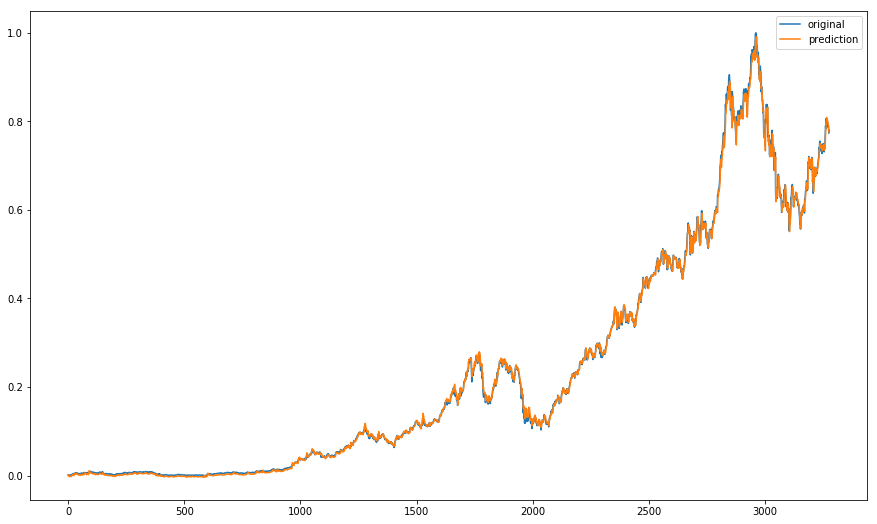

In [36]:
# plot training
plt.plot(trainY)
plt.plot(net(trainX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

In [22]:
# start testing
for i in range(iterations):

    optimizer.zero_grad()
    test_outputs = net(testX_tensor)
    loss = criterion(test_outputs, testY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.0002666992659214884
1 0.00026433973107486963
2 0.0002645730855874717
3 0.0002624874177854508
4 0.0002648396766744554
5 0.0002624115440994501
6 0.0002641375467646867
7 0.0002607009664643556
8 0.00026265866472385824
9 0.00026016071205958724
10 0.0002624206827022135
11 0.0002598752034828067
12 0.0002612336538732052
13 0.000258839747402817
14 0.00026025084662251174
15 0.00025863005430437624
16 0.0002597305574454367
17 0.0002580998989287764
18 0.0002586600021459162
19 0.00025741939316503704
20 0.0002579948341008276
21 0.0002571272198110819
22 0.00025735978852026165
23 0.0002565078320913017
24 0.0002565368195064366
25 0.00025598544743843377
26 0.0002559996792115271
27 0.00025556370383128524
28 0.00025536399334669113
29 0.0002549592172726989
30 0.00025473092682659626
31 0.00025447976076975465
32 0.00025423336774110794
33 0.00025397917488589883
34 0.00025364840985275805
35 0.00025342157459817827
36 0.00025312232901342213
37 0.00025294782244600356
38 0.0002526322496123612
39 0.0002524309093

318 0.00021348010341171175
319 0.00021339826344046742
320 0.00021331672905944288
321 0.00021323547116480768
322 0.00021315438789315522
323 0.00021307359565980732
324 0.00021299312356859446
325 0.00021291273878887296
326 0.0002128327323589474
327 0.00021275288600008935
328 0.0002126733015757054
329 0.00021259402274154127
330 0.0002125148894265294
331 0.0002124360908055678
332 0.00021235753956716508
333 0.00021227917750366032
334 0.0002122009900631383
335 0.00021212315186858177
336 0.00021204548829700798
337 0.00021196810121182352
338 0.00021189094695728272
339 0.00021181405463721603
340 0.00021173732238821685
341 0.00021166086662560701
342 0.00021158465824555606
343 0.0002115087554557249
344 0.00021143291087355465
345 0.00021135738643351942
346 0.00021128208027221262
347 0.0002112070214934647
348 0.00021113218099344522
349 0.00021105757332406938
350 0.0002109831548295915
351 0.00021090898371767253
352 0.0002108351036440581
353 0.0002107614272972569
354 0.0002106878673657775
355 0.000210

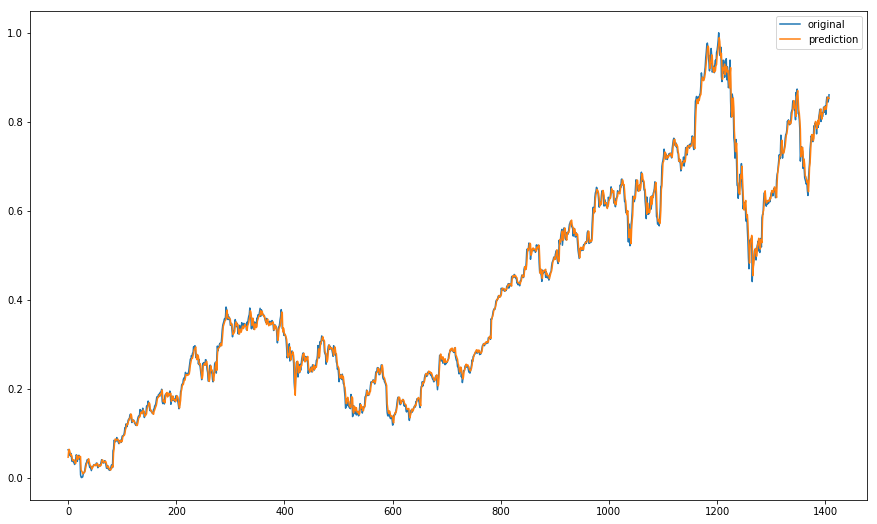

In [37]:
# plot testing
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

### 5. 성능평가

In [24]:
# solve prediction y(tensor) to numpy array
train_predictionY = outputs.detach()
train_predictionY = train_predictionY.numpy()

test_predictionY = test_outputs.detach()
test_predictionY = test_predictionY.numpy()

In [25]:
mean_squared_error(trainY, train_predictionY)

6.680334899007301e-05

In [26]:
mean_squared_error(testY, test_predictionY)

0.0002020649487267671

In [27]:
## RNN
## Test MSE: 6.535761378376095e-05
## Train MSE: 0.00022348110553613228


## LSTM
## Test MSE: 6.259012494261207e-05
## Train MSE: 0.00019432165494639008


## GRU
## Test MSE: 5.0685171742773086e-05
## Train MSE: 0.00023175848398944936

#### 과대적합이 발생한 상황이다.
#### 1. 은닉층 차원 줄이기
#### 2. 시퀀스 길이 늘리기
#### 3. 더 작은 학습률 적용시키기